In [ ]:
# @title LIBRARY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

from scipy.optimize import approx_fprime

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

from torch.utils.data import DataLoader, TensorDataset
import os
import os.path
import time

from torchsummary import summary

In [ ]:
# @title JACOBBIANO analitico 2R PLANARE
def jac2R(j0,j1,Nsample, l=0.1):
  R=np.zeros((Nsample,6))
  for i in range (0,Nsample):
    R[i,0]= -l*np.sin(j0[i])-l*np.sin(j0[i]+j1[i])
    R[i,1]= -l*np.sin(j0[i]+j1[i])
    R[i,2]= l*np.cos(j0[i])+l*np.cos(j0[i]+j1[i])
    R[i,3]= l*np.cos(j0[i]+j1[i])
    R[i,4]= 1
    R[i,5]= 1
  return R


In [ ]:
# @title JACOBBIANO analitico 3R PLANARE
def jac3R(j0,j1,j2,Nsample, l=0.1):
  R=np.zeros((Nsample,3,3))
  for i in range (0,Nsample):
    R[i][0,0]= -l*np.sin(j0[i])-l*np.sin(j0[i]+j1[i]) -l*np.sin(j0[i]+j1[i]+j2[i])
    R[i][0,1]= -l*np.sin(j0[i]+j1[i]) -l*np.sin(j0[i]+j1[i]+j2[i])
    R[i][0,2]= -l*np.sin(j0[i]+j1[i]+j2[i])
    R[i][1,0]= l*np.cos(j0[i])+l*np.cos(j0[i]+j1[i])+l*np.cos(j0[i]+j1[i]+j2[i])
    R[i][1,1]= l*np.cos(j0[i]+j1[i])+l*np.cos(j0[i]+j1[i]+j2[i])
    R[i][1,2]= l*np.cos(j0[i]+j1[i]+j2[i])
    R[i][2,0]= 1
    R[i][2,1]= 1
    R[i][2,2]= 1
  return R


In [ ]:
# @title Classe che implementa l'early stopping e il savebestmodel
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False  # Flag per indicare se interrompere il training
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score - self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
# @title funzione che implementa il training
def train_neural_network(model, train_loader, vali_loader, n_epochs, patience, verbose):
  train_loss_list=[]
  val_loss_list=[]
  early_stopping = EarlyStopping(patience=patience, verbose=verbose)
  for epoch in range(0, n_epochs):

    batch_train_loss=[]
    batch_val_loss=[]
    model.train()
    for xb,yb in train_loader:

      xb=xb.to(device)
      yb=yb.to(device)

      opt.zero_grad()
      pred=model(xb)
      loss=loss_func(yb, pred)
      loss.backward()
      opt.step()
      batch_train_loss.append(loss.item())
    train_loss_list.append(np.mean(batch_train_loss))
    model.eval()
    with torch.no_grad():
      for xb,yb in vali_loader:
        xb=xb.to(device)
        yb=yb.to(device)
        pred=model(xb)
        loss=loss_func(yb, pred)
        batch_val_loss.append(loss.item())
      val_loss_list.append(np.mean(batch_val_loss))
    early_stopping(val_loss_list[epoch], model)
    if early_stopping.early_stop:
      print(f"Early stopping at epoch:{epoch}")
      break
    print(f'Epoch{epoch}---train_loss={train_loss_list[epoch]:.4f}---val_loss={val_loss_list[epoch]:.4f}')
  return train_loss_list,val_loss_list

In [ ]:
# @title data visualization
def data_1k_first_point (df,name):
  num_targets = len(name) # Numero di target
  pose=df[name].to_numpy()

  # Grafico separato per ogni target
  fig, axs = plt.subplots(num_targets, 1, figsize=(18, num_targets * 3))

  for i in range(num_targets):
    axs[i].plot(pose[:1000,i], label=f'{name[i]}')
    axs[i].legend()
    axs[i].set_title(f'{name[i]}')

  plt.tight_layout()
  plt.show()


In [ ]:
# @title Preprocessing dei dati
def preprocessing(input,target,perc_test,shuffle,nn_or_ml):
  x_train, x_test,y_train, y_test = train_test_split(input,target, test_size=perc_test, random_state=1234,shuffle=shuffle)

  scaler = StandardScaler()
  x_train= scaler.fit_transform(x_train)
  x_test = scaler.transform(x_test)
  if nn_or_ml: #true ritorna i dataset per le reti
    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)
    return train_dataset,test_dataset
  else: #false ritornano lo split normale
    return x_train, x_test,y_train, y_test



In [ ]:
# @title funzione che splitta per la cross
def split_for_cross(feature,target,train_index,vali_index,NN_TRUE_ML_FALSE):
  x_train = feature[train_index]
  y_train = target[train_index]
  x_vali = feature[vali_index]
  y_vali = target[vali_index]
  scaler = StandardScaler()
  x_train= scaler.fit_transform(x_train)
  x_vali = scaler.transform(x_vali)
  if NN_TRUE_ML_FALSE:
    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_vali = torch.tensor(x_vali, dtype=torch.float32)
    y_vali = torch.tensor(y_vali, dtype=torch.float32)
    train_dataset = TensorDataset(x_train, y_train)
    vali_dataset = TensorDataset(x_vali, y_vali)
    return train_dataset,vali_dataset
  else:
    return x_train, x_vali,y_train, y_vali

In [ ]:
# @title plot primi risultati
def plot_results(y_pred,y_test,target_name,number_of_sample):
  num_targets = len(target_name)



  fig, axs = plt.subplots(num_targets, 1, figsize=(18, num_targets * 4))
  for i in range(num_targets):
    axs[i].plot(y_pred[0:number_of_sample, i], label=f'Predicted {target_name[i]}',color='blue')
    axs[i].plot(y_test[0:number_of_sample, i], label=f'True {target_name[i]}',color='orange')
    axs[i].legend()
    axs[i].set_title(f'pred vs true {target_name[i]}')

  plt.tight_layout()
  plt.show()




In [ ]:
# @title plot history of training
def plot_history(train_loss_list,val_loss_list,name):
  plt.plot(train_loss_list, label='Training Loss',color='blue', linestyle='-', marker='o')
  plt.plot(val_loss_list, label='Validation Loss',color='orange', linestyle='-', marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'{name}')
  plt.legend()
  plt.grid(True)

  plt.show()
  plt.close()

**Caricamento dati**

In [ ]:
# @title Se vogliamo ragruppare più dati

dftemp=[]
for i in range(0,8):
  dftemp.append(pd.read_csv(f"r3_2{i}_100k.csv",sep=';',header=0))
  print(i)
  dftemp[i].info()

df=pd.concat(dftemp,ignore_index=True)

df.info()
# Salvataggio del DataFrame unito in un file CSV
df.to_csv('r3_20-27.csv', index=False)

# Scarica il file CSV
files.download('r3_20-27.csv')

PRIMO MODULO

In [ ]:
df=pd.read_csv("r3_20_100k.csv",sep=';',header=0)
df.describe()

j0            j1             j2        cos(j0)  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean        0.073610      -0.01434       0.029588      -0.251246   
std         2.175986       1.27951       1.280437       0.732524   
min        -3.387000      -2.01000      -2.030000      -1.000000   
25%        -2.024000      -1.27000      -1.221000      -0.964000   
50%         0.158000      -0.02100       0.062000      -0.507000   
75%         2.176000       1.23400       1.276000       0.457000   
max         3.415000       2.02800       2.024000       1.000000   

             cos(j1)        cos(j2)        sin(j0)        sin(j1)  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.338405       0.337073       0.019818      -0.008034   
std         0.452126       0.451097       0.632391       0.825237   
min        -0.441000      -0.443000      -1.000000      -1.000000   
25%        -0.112000      -0.114000      -0.520000      -0.948000   
50%         0.314000       0.316000       0.010000      -0.021000   
75%         0.792000       0.787000       0.578000       0.941000   
max         1.000000       1.000000       1.000000       1.000000   

             sin(j2)           ee_x           ee_y          ee_qw  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.020218      -0.035947       0.003284       0.321587   
std         0.826137       0.155867       0.151525       0.620216   
min        -1.000000      -0.310000      -0.310000      -1.000000   
25%        -0.937000      -0.174000      -0.125000      -0.122000   
50%         0.062000      -0.046000       0.005000       0.501000   
75%         0.950000       0.085000       0.133000       0.881000   
max         1.000000       0.310000       0.310000       1.000000   

               ee_qz  
count  100000.000000  
mean        0.022351  
std         0.715143  
min        -1.000000  
25%        -0.699000  
50%         0.044000  
75%         0.747000  
max         1.000000

In [ ]:
df.columns

Index(['j0', ' j1', ' j2', ' cos(j0)', ' cos(j1)', ' cos(j2)', ' sin(j0)',
       ' sin(j1)', ' sin(j2)', ' ee_x', ' ee_y', ' ee_qw', ' ee_qz'],
      dtype='object')

In [ ]:
feature2=['j0',' j1', ' j2']
#feature2=[' cos(j0)', ' cos(j1)', ' sin(j0)', ' sin(j1)']
target2=[' ee_x',' ee_y','theta']


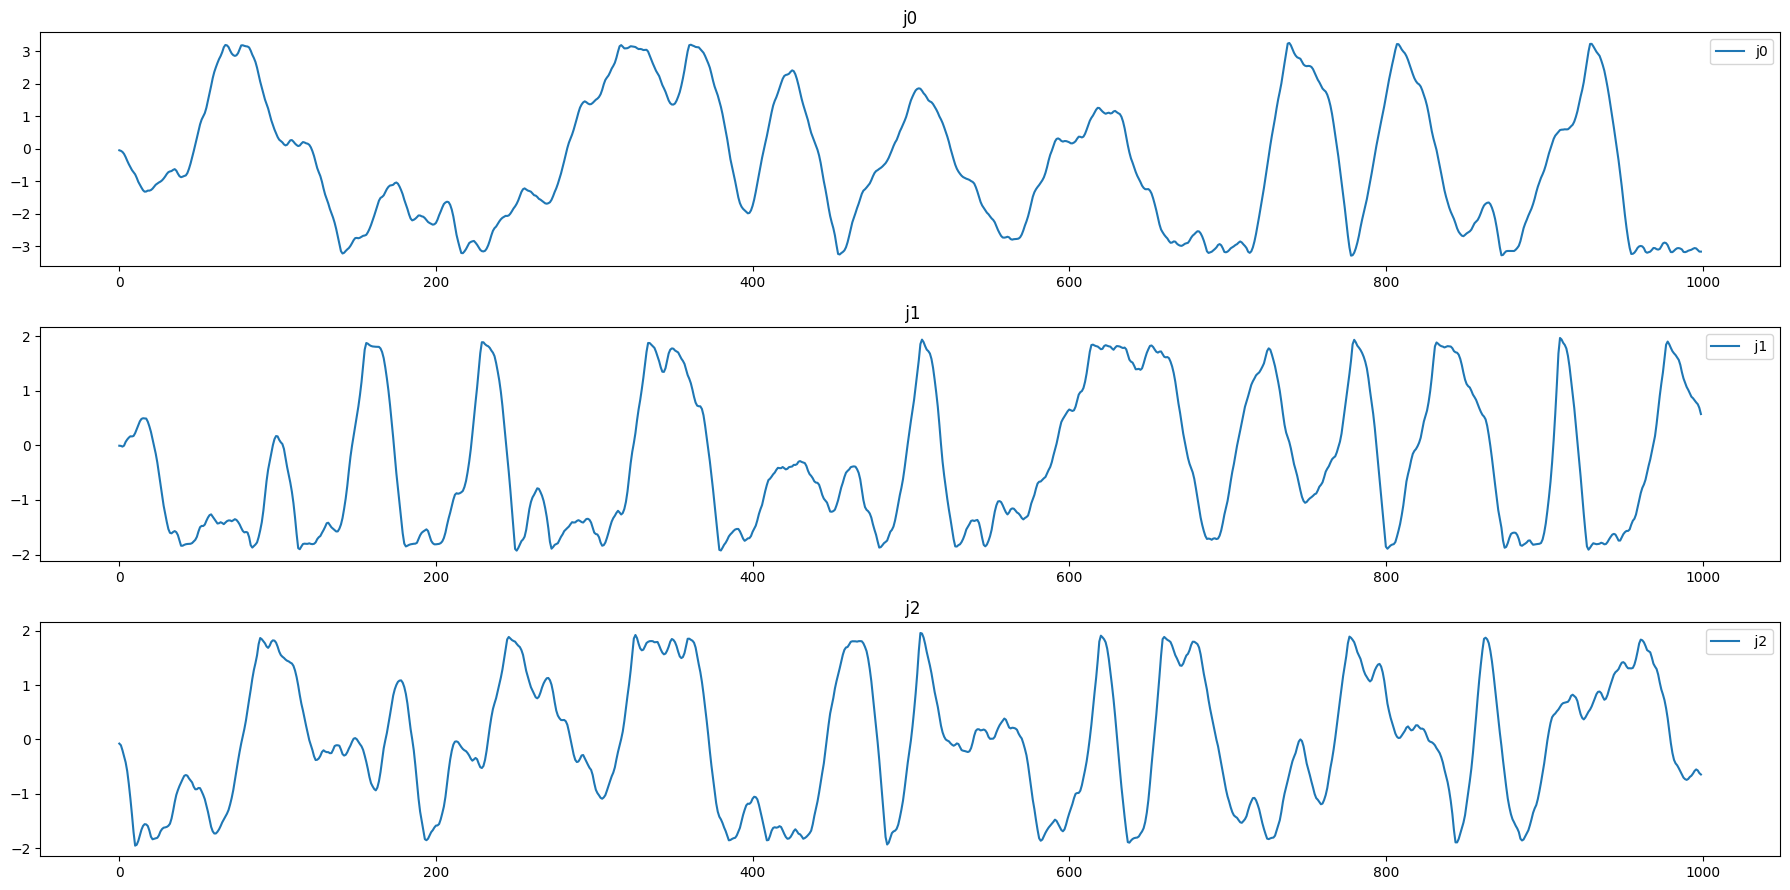

In [ ]:
data_1k_first_point (df,feature2)

In [ ]:
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(0))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla T4
Computation device: cuda



In [ ]:
# @title FEEDFORWARD NEURALNETWORK
class FFNN(nn.Module):
  def __init__(self, input_size, output_size, depth =128, num_layers=3 ,p=0.3):
    super(FFNN, self).__init__()

    self.dropout= nn.Dropout(p)
    self.num_layers=num_layers
    self.depth=depth

    self.input_layer = nn.Linear(input_size , depth)
    self.hidden_layer = nn.Linear(depth, depth)
    self.output_layer = nn.Linear(depth, output_size)
    self.relu=nn.ReLU()

    layers = []

    layers.append(self.input_layer)
    layers.append(self.relu)
    layers.append(self.dropout)

    for _ in range(self.num_layers-2):
      layers.append(self.hidden_layer)
      layers.append(self.relu)
      layers.append(self.dropout)
    layers.append(self.output_layer)

    self.ffnn = nn.Sequential(*layers)

  def forward (self,x):

    out=self.ffnn(x)

    return out

In [ ]:
target2=[' ee_x',' ee_y','theta']
df['theta']=np.arctan2(df[' ee_qz'], df[' ee_qw'])
fea=df[feature2].values
tar=df[target2].values
x_train, x_test,y_train, y_test = train_test_split(fea,tar,test_size=0.2,random_state=1234,shuffle=True)

scaler = StandardScaler()

x_train= scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
vali_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

input_dim = len(feature2)
output_size = len(target2)
n_epochs=50

model= FFNN(input_dim, output_size, 128, 3, 0.0)

model.to(device)

loss_func = nn.MSELoss()

opt = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
t0=time.time()
train_loss_list,val_loss_list = train_neural_network(model, train_loader, vali_loader, n_epochs, patience= 10, verbose=True)
t1=time.time()
print(f'tempo di esecuzione:{t1-t0}')

Validation loss decreased (inf --> 0.072910).  Saving model ...
Epoch0---train_loss=0.0995---val_loss=0.0729
Validation loss decreased (0.072910 --> 0.051933).  Saving model ...
Epoch1---train_loss=0.0575---val_loss=0.0519
Validation loss decreased (0.051933 --> 0.044463).  Saving model ...
Epoch2---train_loss=0.0444---val_loss=0.0445
Validation loss decreased (0.044463 --> 0.039126).  Saving model ...
Epoch3---train_loss=0.0385---val_loss=0.0391
Validation loss decreased (0.039126 --> 0.035941).  Saving model ...
Epoch4---train_loss=0.0349---val_loss=0.0359
Validation loss decreased (0.035941 --> 0.035356).  Saving model ...
Epoch5---train_loss=0.0326---val_loss=0.0354
Validation loss decreased (0.035356 --> 0.034205).  Saving model ...
Epoch6---train_loss=0.0311---val_loss=0.0342
Validation loss decreased (0.034205 --> 0.033450).  Saving model ...
Epoch7---train_loss=0.0298---val_loss=0.0334
Validation loss decreased (0.033450 --> 0.033205).  Saving model ...
Epoch8---train_loss=0.02

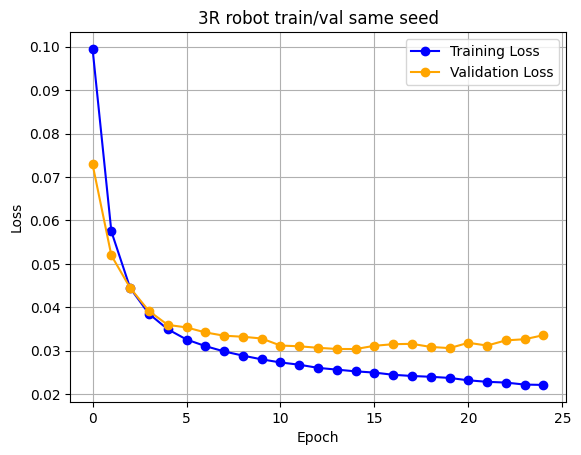

In [ ]:
plot_history(train_loss_list,val_loss_list,'3R robot train/val same seed')

In [ ]:
model.load_state_dict(torch.load('checkpoint.pt'))

<ipython-input-22-04102967a0dd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


<All keys matched successfully>

In [ ]:
model.to('cpu')
y_pred=model(x_test).detach().numpy()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Mean Absolute Error: 0.024540752172470093
Mean Squared Error: 0.030374230816960335


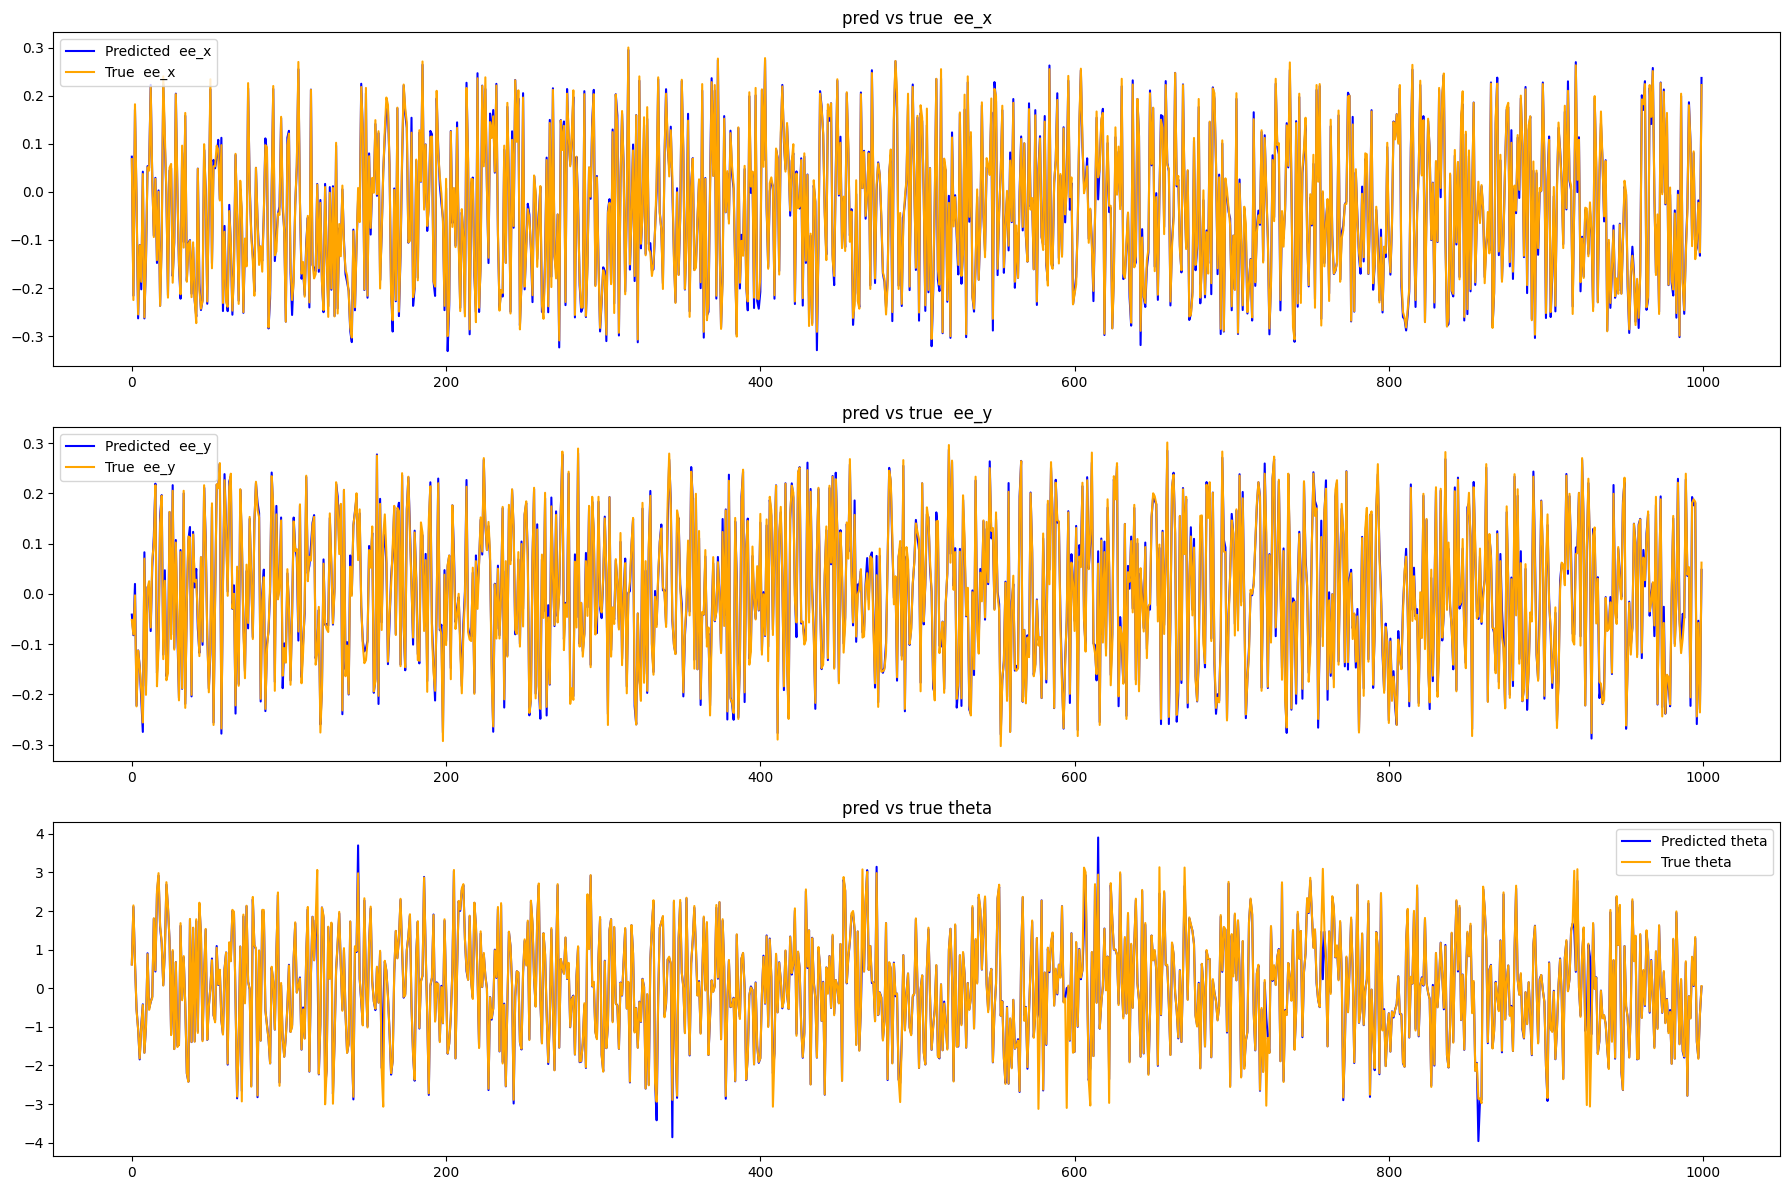

In [ ]:
plot_results(y_pred,y_test,target2,1000)

In [ ]:
jacobian = torch.autograd.functional.jacobian(model, x_test[:1000]).detach().numpy()
#jacobian.reshape(1000,6)
jacobian_analytic = jac3R(x_test[:1000,0],x_test[:1000,1],x_test[:1000,2],len(x_test[:1000]))
jacobian_diag = jacobian[range(1000), :, range(1000), :]
jacobian_diag = jacobian_diag.reshape(1000, -1)
jacobian_analytic=jacobian_analytic.reshape(1000,-1)

print(jacobian_diag.shape)
print(jacobian_analytic.shape)
mae = mean_absolute_error(jacobian_analytic, jacobian_diag)
print(f'Mean Absolute Error: {mae}')

(1000, 9)
(1000, 9)
Mean Absolute Error: 0.3347905920030862


In [ ]:
print(f'jacobian of Neureal Network:{jacobian_diag[40]}')
print(f'jacobian of analytic:{jacobian_analytic[40]}')

jacobian of Neureal Network:[ 0.01819122 -0.15752967  0.09470463 -0.47079736 -0.0044159  -0.16534507
  1.2161654   0.5551593   0.76730114]
jacobian of analytic:[ 0.24620789  0.149193    0.09657515 -0.03483952 -0.05909052  0.02594689
  1.          1.          1.        ]


In [ ]:
df_test=pd.read_csv("r3_21_100k.csv",sep=';',header=0)
df_test.describe()

j0             j1             j2        cos(j0)  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.018123       0.002366       0.021965      -0.281734   
std         2.208295       1.278170       1.286421       0.723340   
min        -3.387000      -2.030000      -2.026000      -1.000000   
25%        -2.141000      -1.252000      -1.244000      -0.970000   
50%         0.023000       0.028000       0.048000      -0.560000   
75%         2.185000       1.240000       1.284000       0.397000   
max         3.386000       2.027000       2.007000       1.000000   

             cos(j1)        cos(j2)        sin(j0)        sin(j1)  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.339721       0.331298      -0.000175       0.003701   
std         0.451714       0.450053       0.630423       0.824954   
min        -0.443000      -0.440000      -1.000000      -1.000000   
25%        -0.112000      -0.118000      -0.548000      -0.945000   
50%         0.319000       0.302000      -0.000000       0.028000   
75%         0.789000       0.780000       0.545000       0.943000   
max         1.000000       1.000000       1.000000       1.000000   

             sin(j2)           ee_x           ee_y          ee_qw  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.014545      -0.040765       0.000768       0.301313   
std         0.829155       0.155509       0.150488       0.627876   
min        -1.000000      -0.310000      -0.310000      -1.000000   
25%        -0.943000      -0.179000      -0.127000      -0.164000   
50%         0.048000      -0.052000       0.002000       0.463000   
75%         0.951000       0.078000       0.129000       0.879000   
max         1.000000       0.310000       0.309000       1.000000   

               ee_qz  
count  100000.000000  
mean        0.012305  
std         0.717528  
min        -1.000000  
25%        -0.715000  
50%         0.020000  
75%         0.744000  
max         1.000000

In [ ]:
x_train=df[feature2].values
df['theta']=np.arctan2(df[' ee_qz'], df[' ee_qw'])
y_train=df[target2].values
x_test=df_test[feature2].values
df_test['theta']=np.arctan2(df_test[' ee_qz'], df_test[' ee_qw'])
y_test=df_test[target2].values

scaler = StandardScaler()

x_train= scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
vali_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

input_dim = len(feature2)
output_size = len(target2)
n_epochs=50

model= FFNN(input_dim, output_size, 128, 3, 0.0)

model.to(device)

loss_func = nn.MSELoss()

opt = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
t0=time.time()
train_loss_list,val_loss_list = train_neural_network(model, train_loader, vali_loader, n_epochs, patience= 10, verbose=True)
t1=time.time()
print(f'tempo di esecuzione:{t1-t0}')

Validation loss decreased (inf --> 0.067000).  Saving model ...
Epoch0---train_loss=0.0932---val_loss=0.0670
Validation loss decreased (0.067000 --> 0.042035).  Saving model ...
Epoch1---train_loss=0.0524---val_loss=0.0420
Validation loss decreased (0.042035 --> 0.030702).  Saving model ...
Epoch2---train_loss=0.0422---val_loss=0.0307
EarlyStopping counter: 1 out of 10
Epoch3---train_loss=0.0371---val_loss=0.0428
Validation loss decreased (0.030702 --> 0.027207).  Saving model ...
Epoch4---train_loss=0.0342---val_loss=0.0272
EarlyStopping counter: 1 out of 10
Epoch5---train_loss=0.0334---val_loss=0.0299
Validation loss decreased (0.027207 --> 0.024465).  Saving model ...
Epoch6---train_loss=0.0312---val_loss=0.0245
EarlyStopping counter: 1 out of 10
Epoch7---train_loss=0.0294---val_loss=0.0285
EarlyStopping counter: 2 out of 10
Epoch8---train_loss=0.0288---val_loss=0.0348
Validation loss decreased (0.024465 --> 0.019789).  Saving model ...
Epoch9---train_loss=0.0285---val_loss=0.0198
E

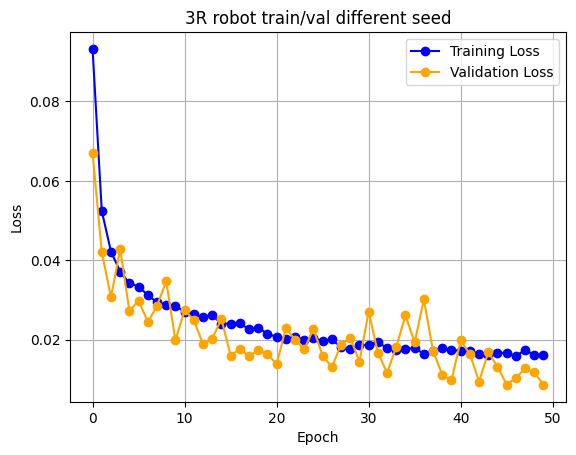

In [ ]:
plot_history(train_loss_list,val_loss_list,'3R robot train/val different seed')

In [ ]:
model.load_state_dict(torch.load('checkpoint.pt'))

<ipython-input-31-04102967a0dd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


<All keys matched successfully>

In [ ]:
model.to('cpu')
y_pred=model(x_test).detach().numpy()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Mean Absolute Error: 0.020211724564433098
Mean Squared Error: 0.008596342988312244


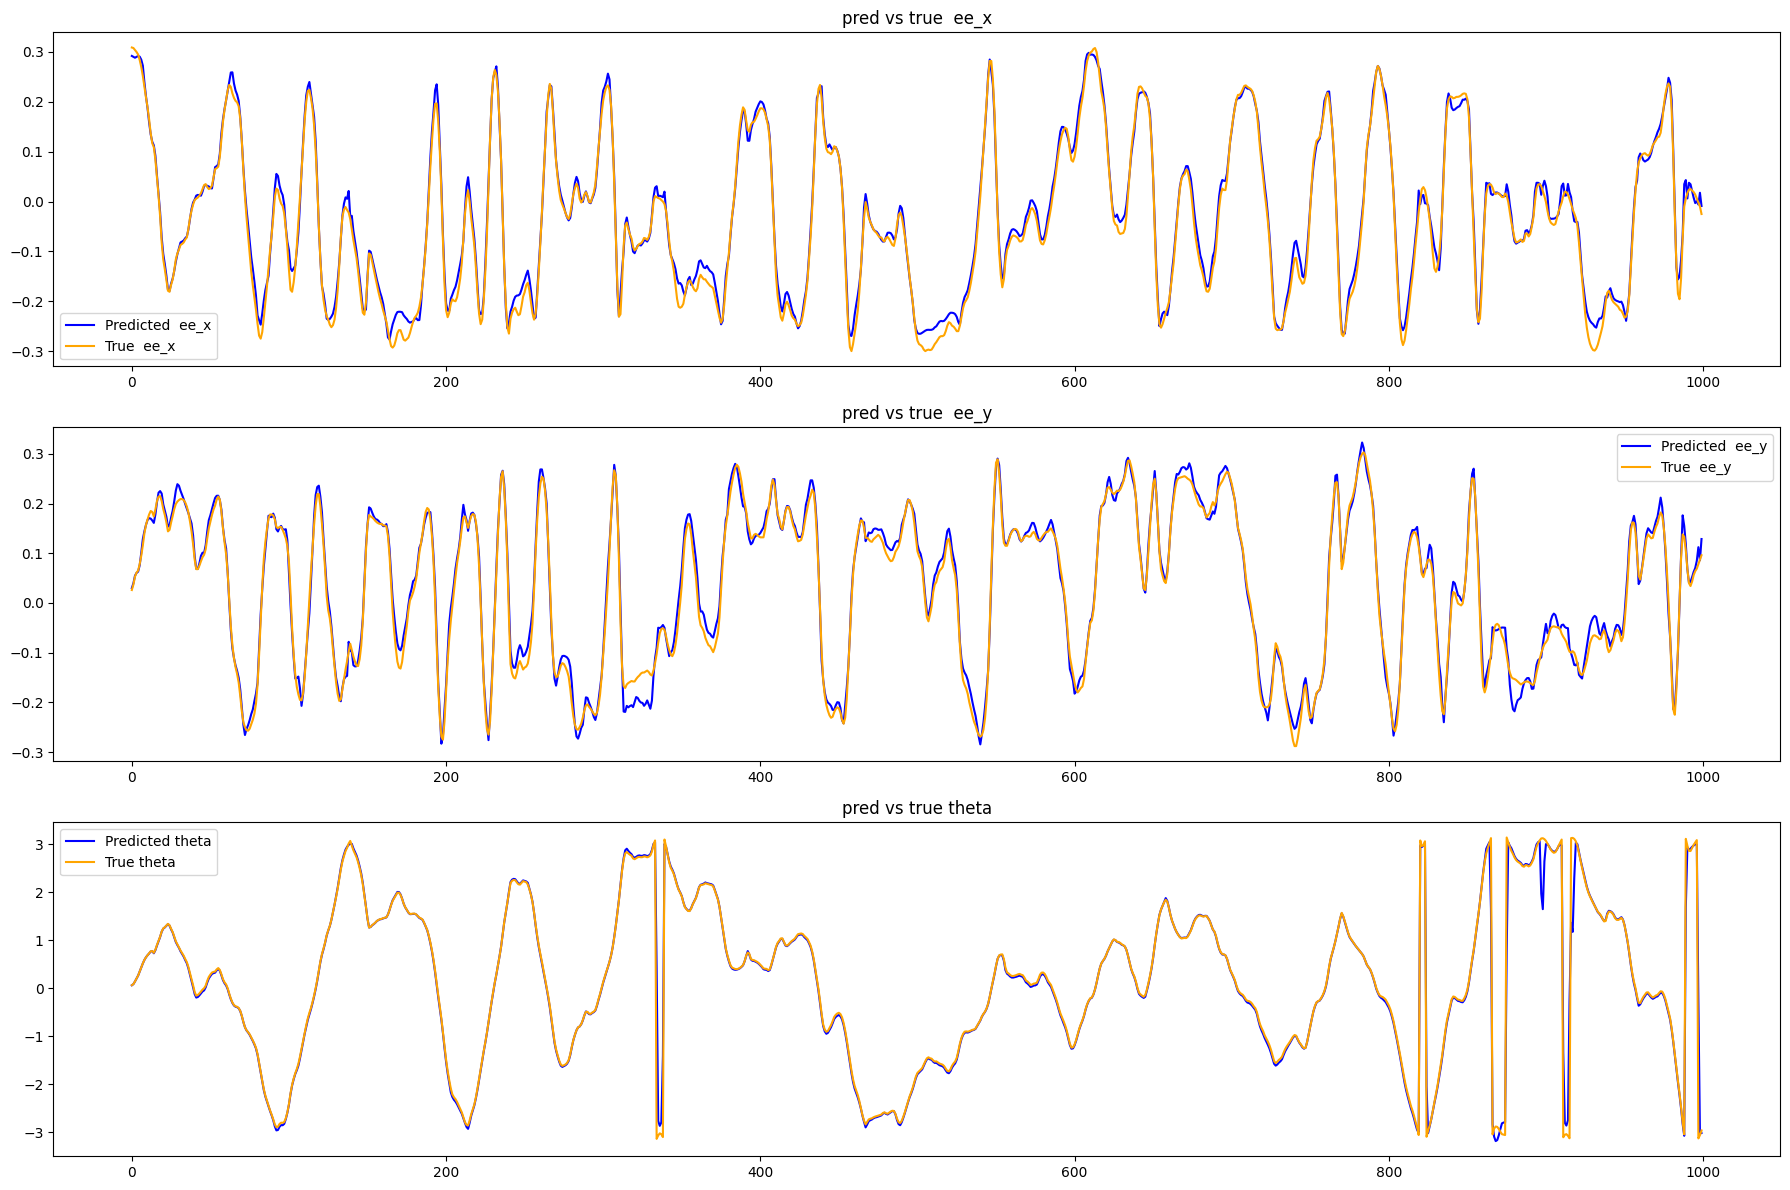

In [ ]:
plot_results(y_pred,y_test,target2,1000)

In [ ]:
jacobian = torch.autograd.functional.jacobian(model, x_test[:1000]).detach().numpy()
#jacobian.reshape(1000,6)
jacobian_analytic = jac3R(x_test[:1000,0],x_test[:1000,1],x_test[:1000,2],len(x_test[:1000]))
jacobian_diag = jacobian[range(1000), :, range(1000), :]
jacobian_diag = jacobian_diag.reshape(1000, -1)
jacobian_analytic=jacobian_analytic.reshape(1000,-1)

print(jacobian_diag.shape)
print(jacobian_analytic.shape)
mae = mean_absolute_error(jacobian_analytic, jacobian_diag)
print(f'Mean Absolute Error: {mae}')

(1000, 9)
(1000, 9)
Mean Absolute Error: 0.4736602054764483


In [ ]:
print(f'jacobian of Neureal Network:{jacobian_diag[40]}')
print(f'jacobian of analytic:{jacobian_analytic[40]}')

jacobian of Neureal Network:[-0.05444789 -0.09067126 -0.02209706 -0.05597504  0.15937123  0.19726261
  1.0736259   0.6173454   0.6586084 ]
jacobian of analytic:[-0.03155681  0.06675312  0.09200299  0.1542519   0.13594455  0.03918482
  1.          1.          1.        ]


In [ ]:
learning_rate=[0.001,0.01]
dropout=[0.1,0.3]
#depth=[128,256]
#num_layers=[3,4]
#weight_decay=[0.001,0.01]
#batch_size=[32,64]

In [ ]:
df=pd.read_csv("r3_20-27.csv")
df.describe()

j0             j1             j2        cos(j0)  \
count  800000.000000  800000.000000  800000.000000  800000.000000   
mean        0.011868       0.000618       0.014624      -0.260188   
std         2.186583       1.278987       1.279361       0.730214   
min        -3.450000      -2.045000      -2.046000      -1.000000   
25%        -2.108000      -1.249000      -1.237000      -0.967000   
50%         0.026000       0.002000       0.030000      -0.523000   
75%         2.132000       1.252000       1.263000       0.446000   
max         3.423000       2.068000       2.044000       1.000000   

             cos(j1)        cos(j2)        sin(j0)        sin(j1)  \
count  800000.000000  800000.000000  800000.000000  800000.000000   
mean        0.338781       0.338399       0.003827       0.000452   
std         0.451198       0.451328       0.631739       0.825626   
min        -0.477000      -0.458000      -1.000000      -1.000000   
25%        -0.111000      -0.112000      -0.544000      -0.944000   
50%         0.315000       0.315000       0.001000       0.002000   
75%         0.790000       0.789000       0.557000       0.945000   
max         1.000000       1.000000       1.000000       1.000000   

             sin(j2)           ee_x          ee_y          ee_qw  \
count  800000.000000  800000.000000  800000.00000  800000.000000   
mean        0.009666      -0.038382       0.00097       0.313406   
std         0.825655       0.156516       0.15110       0.621176   
min        -1.000000      -0.310000      -0.31000      -1.000000   
25%        -0.941000      -0.178000      -0.12800      -0.138000   
50%         0.030000      -0.050000       0.00200       0.484000   
75%         0.947000       0.084000       0.12900       0.879000   
max         1.000000       0.310000       0.31000       1.000000   

               ee_qz  
count  800000.000000  
mean        0.007821  
std         0.718237  
min        -1.000000  
25%        -0.723000  
50%         0.017000  
75%         0.737000  
max         1.000000

In [ ]:
df=pd.read_csv("r3_20-27.csv")
df.describe()
print(df.columns)
feature2=['j0', ' j1', ' j2']
target2=[' ee_x',' ee_y' ,'theta']
fea=df[feature2].values
df['theta']=np.arctan2(df[' ee_qz'], df[' ee_qw'])
tar=df[target2].values

Index(['j0', ' j1', ' j2', ' cos(j0)', ' cos(j1)', ' cos(j2)', ' sin(j0)',
       ' sin(j1)', ' sin(j2)', ' ee_x', ' ee_y', ' ee_qw', ' ee_qz'],
      dtype='object')


In [ ]:
# @title Cross validation for hyperpameter tuning of NN
kf = KFold(n_splits=4, shuffle=True, random_state=1234)
bs=64
nl=3
dp=128
wd=0.001
input_dim = len(feature2)
output_size = len(target2)
dictionary_nn={}

for (train_index, vali_index) in kf.split(fea):
  train_dataset,vali_dataset=split_for_cross(fea,tar,train_index,vali_index,NN_TRUE_ML_FALSE=True)

  for lr in learning_rate:
    for d in dropout:
      #for dp in depth:
        #for nl in num_layers:
          #for wd in weight_decay:
            #for bs in batch_size:
              train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
              vali_loader = DataLoader(vali_dataset, batch_size=bs, shuffle=True)
              model= FFNN(input_dim, output_size, dp, nl, d)
              model.to(device)
              loss_func = nn.MSELoss()
              opt = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
              train_loss_list,val_loss_list = train_neural_network(model, train_loader, vali_loader, n_epochs=10, patience=5, verbose=False)
              best_model=torch.load('checkpoint.pt')
              model.load_state_dict(best_model)
              y_pred=model(vali_dataset.tensors[0].to(device)).cpu().detach().numpy()
              mae = mean_absolute_error(vali_dataset.tensors[1].numpy(), y_pred)
              if (lr,d,dp,nl,wd,bs) not in dictionary_nn:
                dictionary_nn[(lr,d,dp,nl,wd,bs)]=[]
                print('pluto  ')
              dictionary_nn[(lr,d,dp,nl,wd,bs)].append(mae)
              print(f'Mean Absolute Error:{mae} lr:{lr} ,dropout:{d},depth:{dp},num_layers:{nl},weight_decay:{wd},batch_size:{bs}')


Epoch0---train_loss=0.0932---val_loss=0.0517
Epoch1---train_loss=0.0579---val_loss=0.0406
Epoch2---train_loss=0.0510---val_loss=0.0374
Epoch3---train_loss=0.0490---val_loss=0.0420
Epoch4---train_loss=0.0475---val_loss=0.0351
Epoch5---train_loss=0.0461---val_loss=0.0347
Epoch6---train_loss=0.0446---val_loss=0.0346
Epoch7---train_loss=0.0432---val_loss=0.0396
Epoch8---train_loss=0.0425---val_loss=0.0348
Epoch9---train_loss=0.0420---val_loss=0.0392
pluto  
Mean Absolute Error:0.05613738298416138 lr:0.001 ,dropout:0.1,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.1140---val_loss=0.0679
Epoch1---train_loss=0.0771---val_loss=0.0519
Epoch2---train_loss=0.0686---val_loss=0.0459
Epoch3---train_loss=0.0653---val_loss=0.0484
Epoch4---train_loss=0.0624---val_loss=0.0505
Epoch5---train_loss=0.0621---val_loss=0.0431
Epoch6---train_loss=0.0605---val_loss=0.0388
Epoch7---train_loss=0.0600---val_loss=0.0395
Epoch8---train_loss=0.0592---val_loss=0.0402
Epoch9---train_loss=0.0581---val_loss=0.0434
pluto  
Mean Absolute Error:0.06320392340421677 lr:0.001 ,dropout:0.3,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.1009---val_loss=0.0585
Epoch1---train_loss=0.0769---val_loss=0.0542
Epoch2---train_loss=0.0762---val_loss=0.0602
Epoch3---train_loss=0.0757---val_loss=0.0460
Epoch4---train_loss=0.0753---val_loss=0.0860
Epoch5---train_loss=0.0741---val_loss=0.0507
Epoch6---train_loss=0.0736---val_loss=0.0613
Epoch7---train_loss=0.0740---val_loss=0.0584
Early stopping at epoch:8
pluto  
Mean Absolute Error:0.08398961275815964 lr:0.01 ,dropout:0.1,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.1523---val_loss=0.1219
Epoch1---train_loss=0.1459---val_loss=0.1237
Epoch2---train_loss=0.1456---val_loss=0.1340
Epoch3---train_loss=0.1431---val_loss=0.1225
Epoch4---train_loss=0.1417---val_loss=0.1216
Epoch5---train_loss=0.1418---val_loss=0.1218
Epoch6---train_loss=0.1420---val_loss=0.1204
Epoch7---train_loss=0.1414---val_loss=0.1211
Epoch8---train_loss=0.1413---val_loss=0.1222
Epoch9---train_loss=0.1416---val_loss=0.1182
pluto  
Mean Absolute Error:0.10697931051254272 lr:0.01 ,dropout:0.3,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.0881---val_loss=0.0573
Epoch1---train_loss=0.0507---val_loss=0.0436
Epoch2---train_loss=0.0456---val_loss=0.0396
Epoch3---train_loss=0.0438---val_loss=0.0330
Epoch4---train_loss=0.0427---val_loss=0.0390
Epoch5---train_loss=0.0421---val_loss=0.0354
Epoch6---train_loss=0.0412---val_loss=0.0334
Epoch7---train_loss=0.0412---val_loss=0.0304
Epoch8---train_loss=0.0409---val_loss=0.0391
Epoch9---train_loss=0.0404---val_loss=0.0346
Mean Absolute Error:0.04369090870022774 lr:0.001 ,dropout:0.1,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.1084---val_loss=0.0638
Epoch1---train_loss=0.0732---val_loss=0.0502
Epoch2---train_loss=0.0661---val_loss=0.0446
Epoch3---train_loss=0.0635---val_loss=0.0479
Epoch4---train_loss=0.0621---val_loss=0.0439
Epoch5---train_loss=0.0608---val_loss=0.0412
Epoch6---train_loss=0.0597---val_loss=0.0387
Epoch7---train_loss=0.0589---val_loss=0.0365
Epoch8---train_loss=0.0579---val_loss=0.0424
Epoch9---train_loss=0.0574---val_loss=0.0423
Mean Absolute Error:0.07147479802370071 lr:0.001 ,dropout:0.3,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.0952---val_loss=0.0545
Epoch1---train_loss=0.0744---val_loss=0.0637
Epoch2---train_loss=0.0724---val_loss=0.0494
Epoch3---train_loss=0.0726---val_loss=0.0446
Epoch4---train_loss=0.0716---val_loss=0.0556
Epoch5---train_loss=0.0721---val_loss=0.0642
Epoch6---train_loss=0.0759---val_loss=0.0484
Epoch7---train_loss=0.0710---val_loss=0.0580
Early stopping at epoch:8
Mean Absolute Error:0.07905856519937515 lr:0.01 ,dropout:0.1,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.1487---val_loss=0.1222
Epoch1---train_loss=0.1270---val_loss=0.1002
Epoch2---train_loss=0.1238---val_loss=0.0971
Epoch3---train_loss=0.1229---val_loss=0.0982
Epoch4---train_loss=0.1222---val_loss=0.1011
Epoch5---train_loss=0.1220---val_loss=0.0979
Epoch6---train_loss=0.1207---val_loss=0.1011
Early stopping at epoch:7
Mean Absolute Error:0.11679651588201523 lr:0.01 ,dropout:0.3,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.0869---val_loss=0.0596
Epoch1---train_loss=0.0541---val_loss=0.0451
Epoch2---train_loss=0.0498---val_loss=0.0377
Epoch3---train_loss=0.0469---val_loss=0.0367
Epoch4---train_loss=0.0451---val_loss=0.0377
Epoch5---train_loss=0.0437---val_loss=0.0396
Epoch6---train_loss=0.0433---val_loss=0.0337
Epoch7---train_loss=0.0425---val_loss=0.0324
Epoch8---train_loss=0.0421---val_loss=0.0349
Epoch9---train_loss=0.0416---val_loss=0.0364
Mean Absolute Error:0.04947670176625252 lr:0.001 ,dropout:0.1,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.1102---val_loss=0.0720
Epoch1---train_loss=0.0732---val_loss=0.0521
Epoch2---train_loss=0.0647---val_loss=0.0458
Epoch3---train_loss=0.0620---val_loss=0.0417
Epoch4---train_loss=0.0601---val_loss=0.0472
Epoch5---train_loss=0.0586---val_loss=0.0411
Epoch6---train_loss=0.0579---val_loss=0.0421
Epoch7---train_loss=0.0578---val_loss=0.0497
Epoch8---train_loss=0.0576---val_loss=0.0431
Epoch9---train_loss=0.0569---val_loss=0.0360
Mean Absolute Error:0.06832747906446457 lr:0.001 ,dropout:0.3,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.0946---val_loss=0.0559
Epoch1---train_loss=0.0738---val_loss=0.0564
Epoch2---train_loss=0.0718---val_loss=0.0561
Epoch3---train_loss=0.0711---val_loss=0.0551
Epoch4---train_loss=0.0720---val_loss=0.0546
Epoch5---train_loss=0.0717---val_loss=0.0563
Epoch6---train_loss=0.0717---val_loss=0.0532
Epoch7---train_loss=0.0717---val_loss=0.0631
Epoch8---train_loss=0.0712---val_loss=0.0485
Epoch9---train_loss=0.0719---val_loss=0.0466
Mean Absolute Error:0.06842748820781708 lr:0.01 ,dropout:0.1,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.1499---val_loss=0.1221
Epoch1---train_loss=0.1453---val_loss=0.1205
Epoch2---train_loss=0.1431---val_loss=0.1256
Epoch3---train_loss=0.1414---val_loss=0.1273
Epoch4---train_loss=0.1406---val_loss=0.1246
Epoch5---train_loss=0.1404---val_loss=0.1265
Early stopping at epoch:6
Mean Absolute Error:0.12049069255590439 lr:0.01 ,dropout:0.3,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.0896---val_loss=0.0514
Epoch1---train_loss=0.0555---val_loss=0.0409
Epoch2---train_loss=0.0509---val_loss=0.0379
Epoch3---train_loss=0.0479---val_loss=0.0391
Epoch4---train_loss=0.0465---val_loss=0.0350
Epoch5---train_loss=0.0443---val_loss=0.0362
Epoch6---train_loss=0.0431---val_loss=0.0370
Epoch7---train_loss=0.0424---val_loss=0.0331
Epoch8---train_loss=0.0422---val_loss=0.0359
Epoch9---train_loss=0.0420---val_loss=0.0348
Mean Absolute Error:0.05438931658864021 lr:0.001 ,dropout:0.1,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.1177---val_loss=0.0762
Epoch1---train_loss=0.0823---val_loss=0.0581
Epoch2---train_loss=0.0731---val_loss=0.0478
Epoch3---train_loss=0.0676---val_loss=0.0477
Epoch4---train_loss=0.0641---val_loss=0.0415
Epoch5---train_loss=0.0617---val_loss=0.0407
Epoch6---train_loss=0.0604---val_loss=0.0382
Epoch7---train_loss=0.0600---val_loss=0.0449
Epoch8---train_loss=0.0590---val_loss=0.0436
Epoch9---train_loss=0.0589---val_loss=0.0385
Mean Absolute Error:0.0719621405005455 lr:0.001 ,dropout:0.3,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.0969---val_loss=0.0596
Epoch1---train_loss=0.0753---val_loss=0.0545
Epoch2---train_loss=0.0733---val_loss=0.0501
Epoch3---train_loss=0.0734---val_loss=0.0485
Epoch4---train_loss=0.0741---val_loss=0.0650
Epoch5---train_loss=0.0726---val_loss=0.0583
Epoch6---train_loss=0.0722---val_loss=0.0505
Epoch7---train_loss=0.0734---val_loss=0.0515
Epoch8---train_loss=0.0725---val_loss=0.0444
Epoch9---train_loss=0.0718---val_loss=0.0469
Mean Absolute Error:0.07761538028717041 lr:0.01 ,dropout:0.1,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


Epoch0---train_loss=0.1510---val_loss=0.1138
Epoch1---train_loss=0.1437---val_loss=0.1256
Epoch2---train_loss=0.1455---val_loss=0.1224
Epoch3---train_loss=0.1436---val_loss=0.1243
Epoch4---train_loss=0.1417---val_loss=0.1220
Early stopping at epoch:5
Mean Absolute Error:0.13203097879886627 lr:0.01 ,dropout:0.3,depth:128,num_layers:3,weight_decay:0.001,batch_size:64


<ipython-input-40-15c17a53299e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load('checkpoint.pt')


In [ ]:
# @title Risultato per la cross_val per NN
for lr in learning_rate:
  for d in dropout:
    #for dp in depth:
      #for nl in num_layers:
        #for wd in weight_decay:
          #for bs in batch_size:
            mean=np.mean(dictionary_nn[(lr,d,dp,nl,wd,bs)])
            std=np.std(dictionary_nn[(lr,d,dp,nl,wd,bs)])
            print(f'score of--lr:{lr}--d:{d}--dp:{dp}--wd:{wd}--:bs{bs}-->mean:{mean:.6}(+/-){(std*2):.6}')


score of--lr:0.001--d:0.1--dp:128--wd:0.001--:bs64-->mean:0.0509236(+/-)0.00967471
score of--lr:0.001--d:0.3--dp:128--wd:0.001--:bs64-->mean:0.0687421(+/-)0.00697708
score of--lr:0.01--d:0.1--dp:128--wd:0.001--:bs64-->mean:0.0772728(+/-)0.0112544
score of--lr:0.01--d:0.3--dp:128--wd:0.001--:bs64-->mean:0.119074(+/-)0.0179265


In [ ]:
print(dictionary_nn.keys())

dict_keys([(0.001, 0.1, 128, 3, 0.001, 64), (0.001, 0.3, 128, 3, 0.001, 64), (0.01, 0.1, 128, 3, 0.001, 64), (0.01, 0.3, 128, 3, 0.001, 64)])


In [ ]:
d=0.1
lr=0.001
dp=128
wd=0.001

In [ ]:
df_test=pd.read_csv("r3_28_100k.csv",sep=';',header=0)
x_train=fea
y_train=tar
x_test=df_test[feature2].values
df_test['theta']=np.arctan2(df_test[' ee_qz'], df_test[' ee_qw'])
y_test=df_test[target2].values

scaler = StandardScaler()

x_train=scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
vali_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [ ]:
model = FFNN(input_dim, output_size, 128 ,nl, 0.1)
model.to(device)
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
import time
t0=time.time()
train_loss_list,val_loss_list = train_neural_network(model, train_loader, vali_loader, n_epochs=50, patience=10, verbose=True)
t1=time.time()
print(f'tempo di esecuzione:{t1-t0}')

Validation loss decreased (inf --> 0.047638).  Saving model ...
Epoch0---train_loss=0.0781---val_loss=0.0476
EarlyStopping counter: 1 out of 10
Epoch1---train_loss=0.0520---val_loss=0.0620
Validation loss decreased (0.047638 --> 0.045583).  Saving model ...
Epoch2---train_loss=0.0495---val_loss=0.0456
Validation loss decreased (0.045583 --> 0.037614).  Saving model ...
Epoch3---train_loss=0.0477---val_loss=0.0376
Validation loss decreased (0.037614 --> 0.034428).  Saving model ...
Epoch4---train_loss=0.0455---val_loss=0.0344
EarlyStopping counter: 1 out of 10
Epoch5---train_loss=0.0433---val_loss=0.0388
Validation loss decreased (0.034428 --> 0.033150).  Saving model ...
Epoch6---train_loss=0.0425---val_loss=0.0332
EarlyStopping counter: 1 out of 10
Epoch7---train_loss=0.0419---val_loss=0.0361
EarlyStopping counter: 2 out of 10
Epoch8---train_loss=0.0413---val_loss=0.0338
EarlyStopping counter: 3 out of 10
Epoch9---train_loss=0.0412---val_loss=0.0361
EarlyStopping counter: 4 out of 10


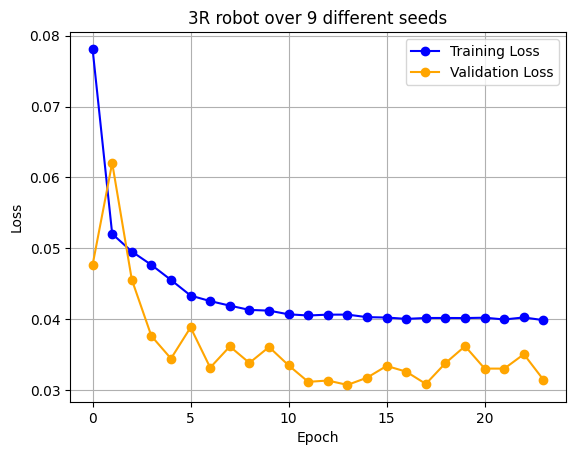

In [ ]:
plot_history(train_loss_list,val_loss_list,'3R robot over 9 different seeds')

In [ ]:
model.load_state_dict(torch.load('checkpoint.pt'))

<ipython-input-56-04102967a0dd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


<All keys matched successfully>

In [ ]:
model.to('cpu')
y_pred=model(x_test).detach().numpy()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Mean Absolute Error: 0.046974826604127884
Mean Squared Error: 0.030715228989720345


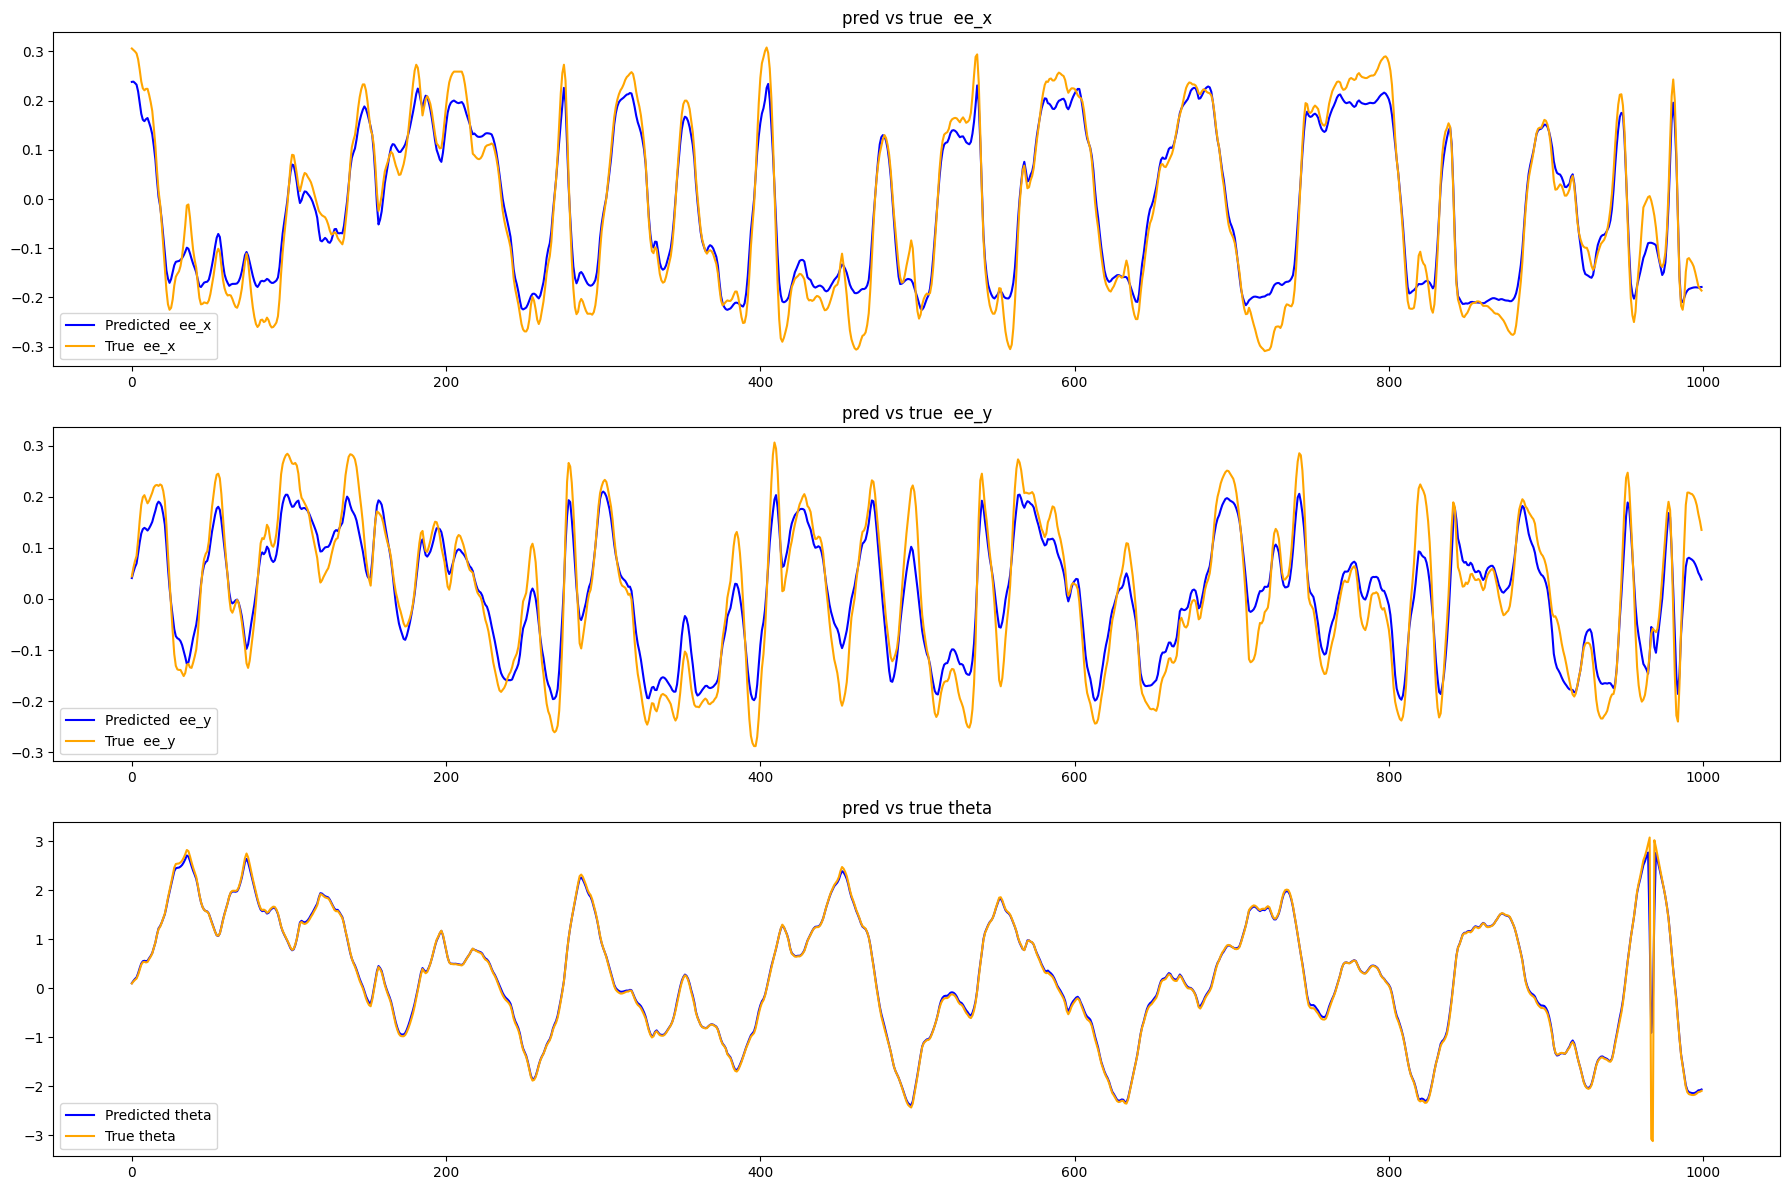

In [ ]:
plot_results(y_pred,y_test,target2,1000)

SECONDO MODULO

In [ ]:
df=pd.read_csv("r2_20_100k.csv",sep=';',header=0)
df.describe()

j0             j1        cos(j0)        cos(j1)  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.011472       0.049091      -0.267659      -0.221244   
std         2.195877       2.088708       0.728443       0.718237   
min        -3.389000      -3.262000      -1.000000      -1.000000   
25%        -2.128000      -1.969000      -0.969000      -0.923000   
50%         0.023000       0.085000      -0.534000      -0.435000   
75%         2.141000       2.071250       0.431000       0.469000   
max         3.441000       3.255000       1.000000       1.000000   

             sin(j0)       sin(j1)           ee_x           ee_y  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean        0.002480       0.01003      -0.021101      -0.001026   
std         0.630674       0.65962       0.094407       0.088737   
min        -1.000000      -1.00000      -0.210000      -0.210000   
25%        -0.543000      -0.60000      -0.083000      -0.057000   
50%         0.000000       0.04600      -0.010000       0.000000   
75%         0.549000       0.61800       0.025000       0.055000   
max         1.000000       1.00000       0.210000       0.210000   

               ee_qw          ee_qz  
count  100000.000000  100000.000000  
mean        0.252359       0.014498  
std         0.679756       0.688513  
min        -1.000000      -1.000000  
25%        -0.357000      -0.654000  
50%         0.458000       0.021000  
75%         0.892000       0.690000  
max         1.000000       1.000000

In [ ]:
df.columns

Index(['j0', ' j1', ' cos(j0)', ' cos(j1)', ' sin(j0)', ' sin(j1)', ' ee_x',
       ' ee_y', ' ee_qw', ' ee_qz'],
      dtype='object')

In [ ]:
feature2=['j0', ' j1']
target2=[' ee_x',' ee_y','theta']
df['theta']=np.arctan2(df[' ee_qz'], df[' ee_qw'])
fea=df[feature2].values
tar=df[target2].values

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(fea,tar,test_size=0.2,random_state=1234,shuffle=True)

scaler = StandardScaler()

x_train= scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
base_model = GradientBoostingRegressor(loss='squared_error',  n_estimators=50,learning_rate=0.1,random_state=1234)

model = MultiOutputRegressor(base_model)
import time
t0=time.time()
model.fit(x_train, y_train)
t1=time.time()
print(f'tempo di esecuzione:{t1-t0}')



tempo di esecuzione:11.680935621261597


In [ ]:
y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.007794651612911729
Mean Absolute Error: 0.03427041382070634


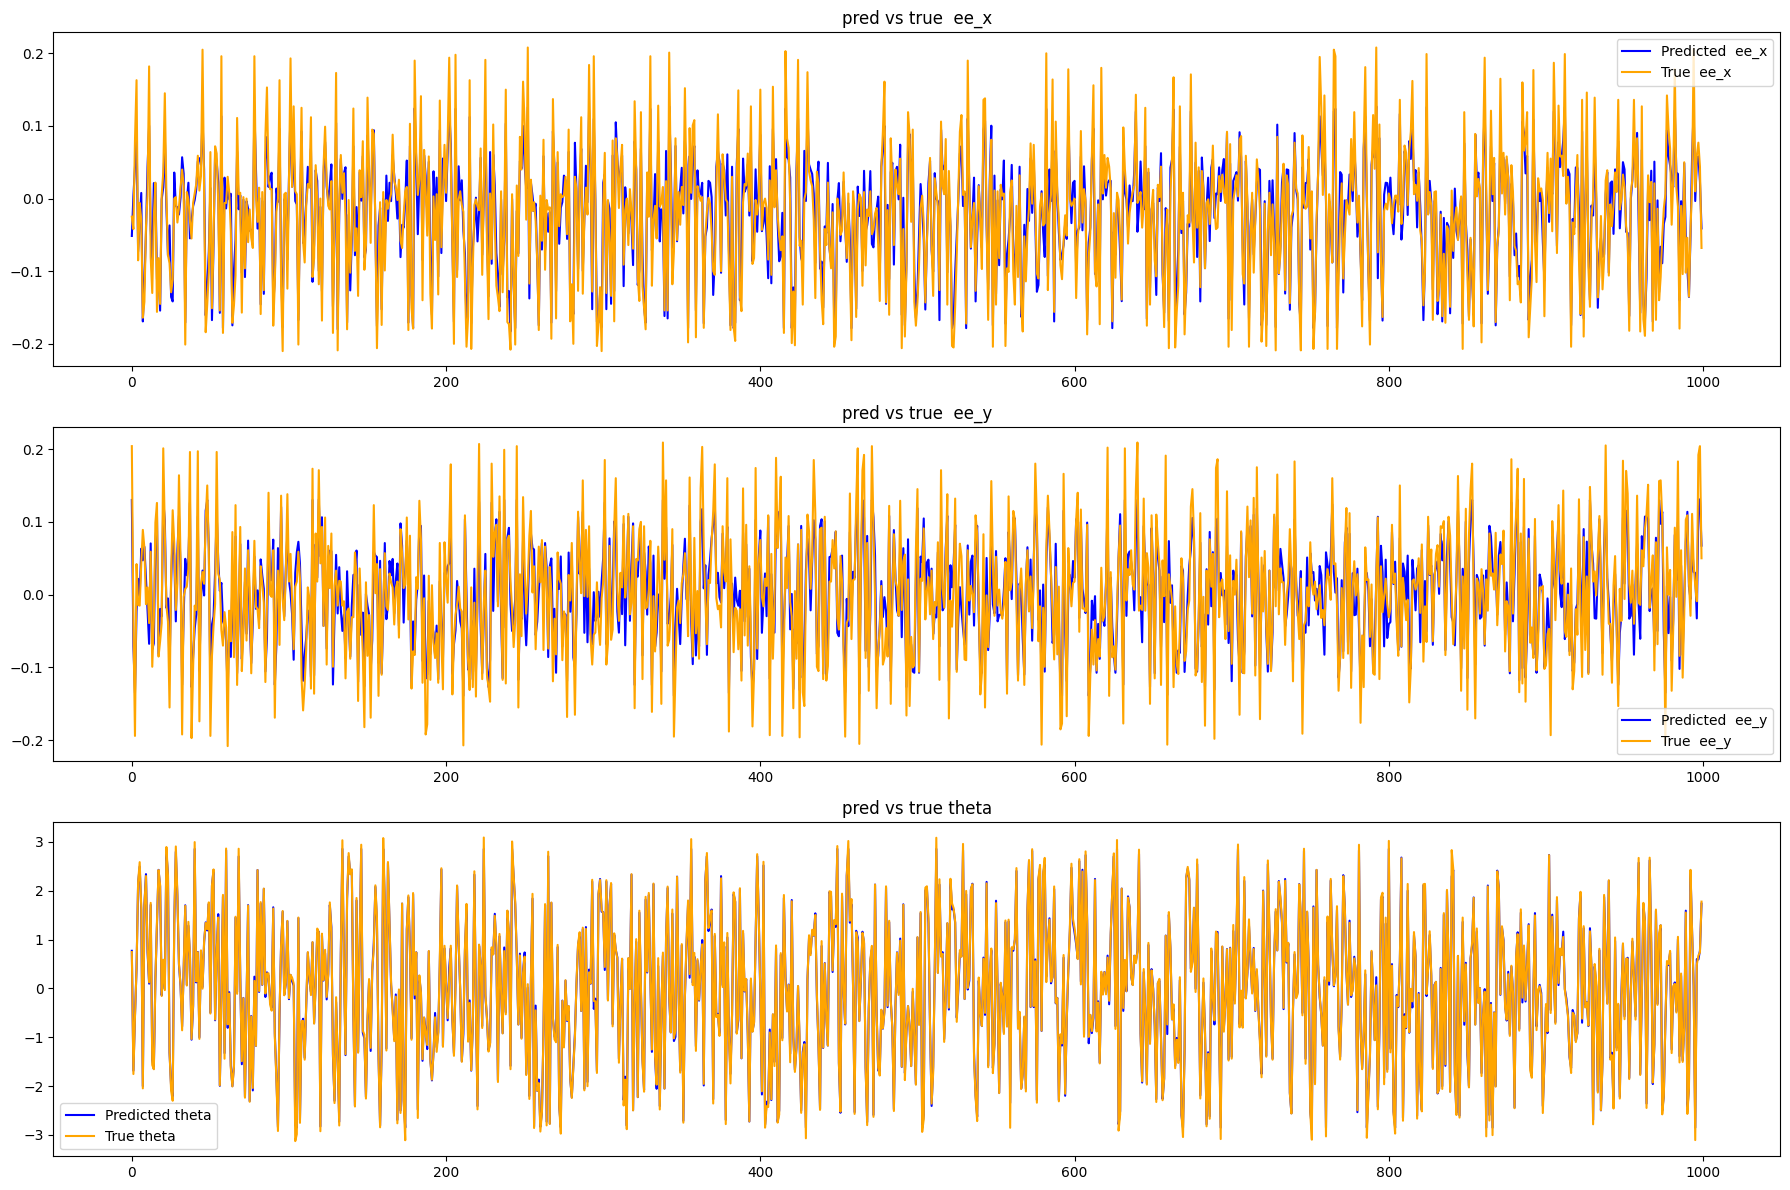

In [ ]:
plot_results(y_pred,y_test,target2,1000)

In [ ]:
df_test=pd.read_csv("r2_21_100k.csv",sep=';',header=0)
df_test['theta']=np.arctan2(df_test[' ee_qz'], df_test[' ee_qw'])

x_train=df[feature2].values
y_train=df[target2].values
x_test=df_test[feature2].values
y_test=df_test[target2].values

scaler = StandardScaler()

x_train= scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [ ]:
base_model = GradientBoostingRegressor(loss='squared_error',  n_estimators=50,learning_rate=0.1,random_state=1234)
t0=time.time()
model = MultiOutputRegressor(base_model)

model.fit(x_train, y_train)
t1=time.time()
print(f'tempo di esecuzione:{t1-t0}')

tempo di esecuzione:15.005586862564087


In [ ]:
y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.00990667119371586
Mean Absolute Error: 0.03496488472250362


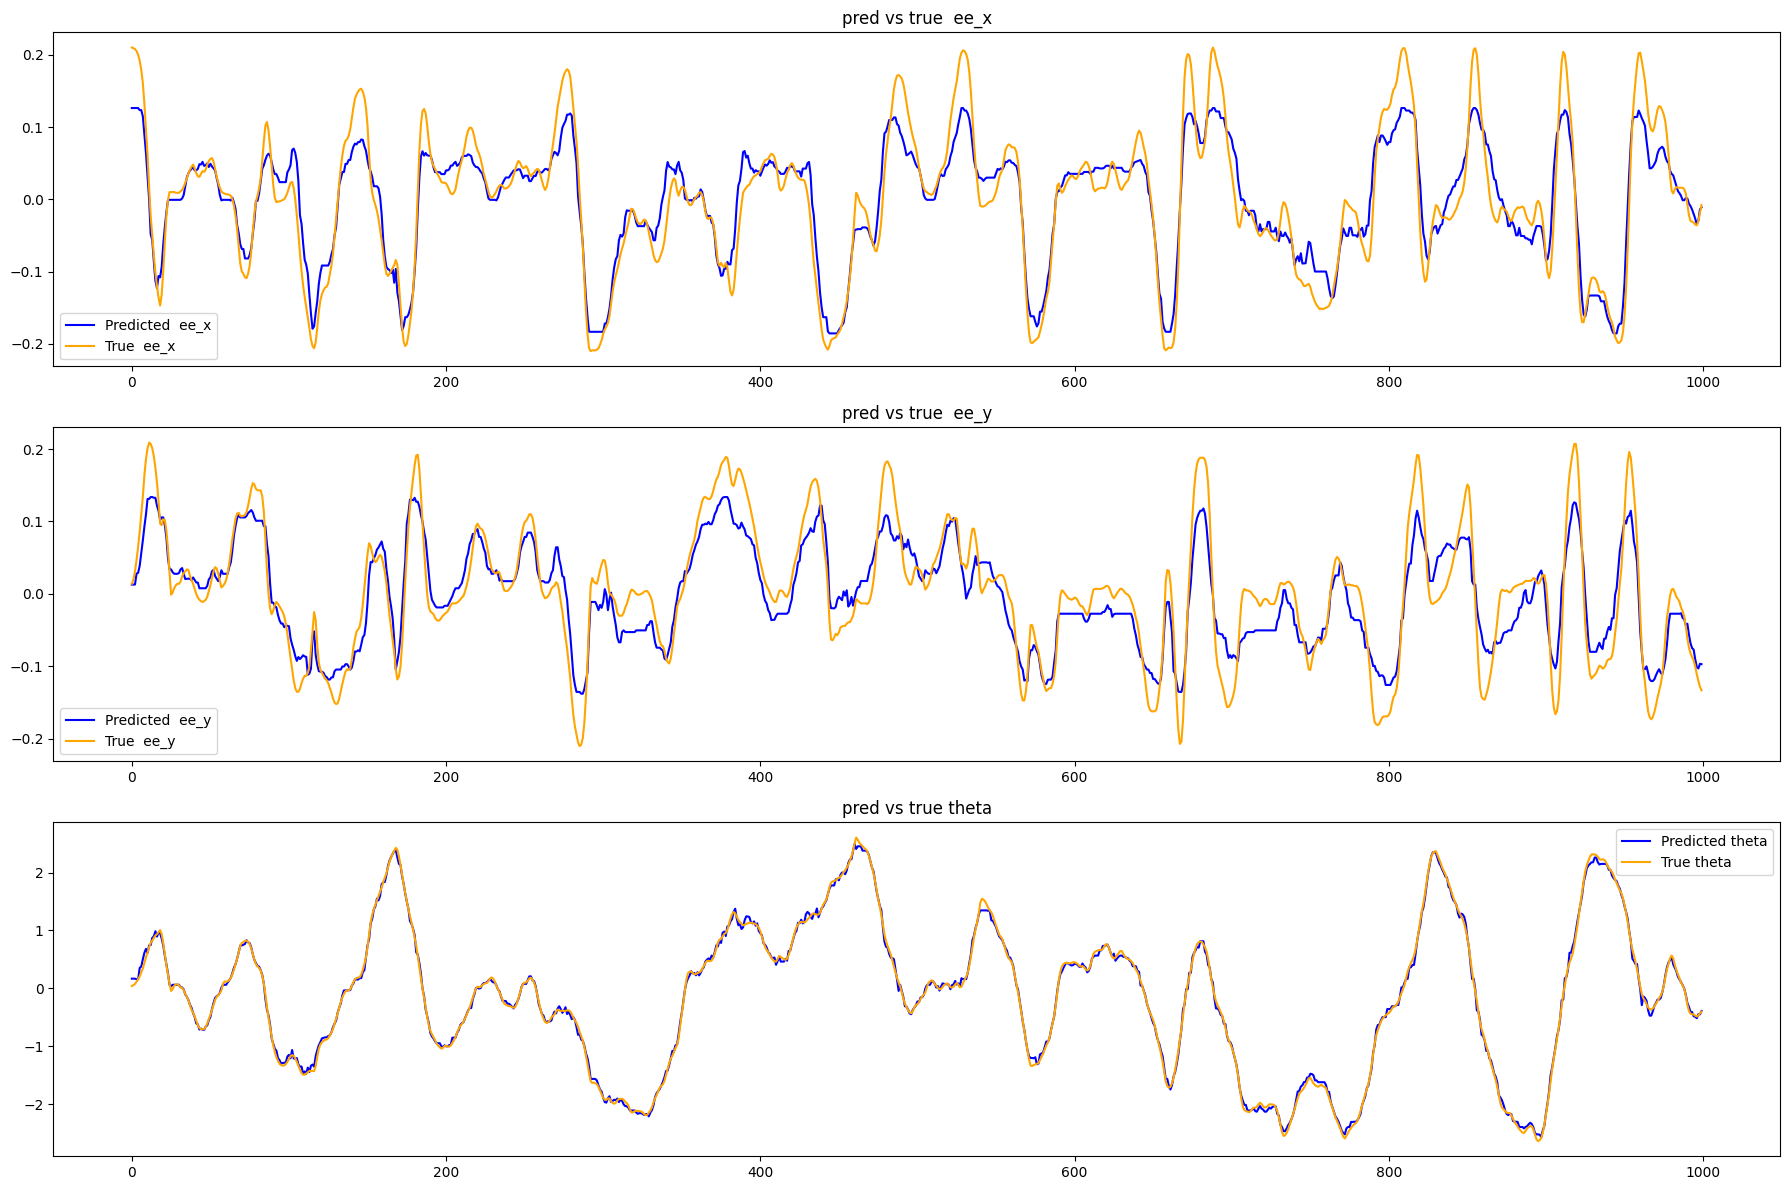

In [ ]:
plot_results(y_pred,y_test,target2,1000)

In [ ]:
df=pd.read_csv("r2_20-27.csv")
df['theta']=np.arctan2(df[' ee_qz'], df[' ee_qw'])
fea=df[feature2].values
tar=df[target2].values

In [ ]:
n_estimators=[50,100,150]
learning_rate=[0.01,0.1,1]


In [ ]:
# @title Hyparameter definition
k_neighbors=[3,5,7]
weights=['uniform','distance']

learning_rate=[0.001,0.01,0.1]
dropout=[0,0.1,0.3]
depth=[128,256,512]
num_layers=[3,4,5]
weight_decay=[0,0.001,0.01]
batch_size=[32,64,128]


In [ ]:
kf=KFold(n_splits=4,shuffle=True,random_state=1234)

score_dictionary={}

for (train_index, vali_index) in kf.split(fea):
  x_train = fea[train_index]
  y_train = tar[train_index]
  x_vali = fea[vali_index]
  y_vali = tar[vali_index]

  scaler = StandardScaler()
  x_train= scaler.fit_transform(x_train)
  x_vali = scaler.transform(x_vali)

  for n in n_estimators:
    for lr in learning_rate:
      base_model = GradientBoostingRegressor(loss='squared_error',  n_estimators=n,learning_rate=lr,random_state=1234)
      model = MultiOutputRegressor(base_model)
      model.fit(x_train, y_train)
      y_pred = model.predict(x_vali)

      #mse = mean_squared_error(y_vali, y_pred)
      mae = mean_absolute_error(y_vali, y_pred)

      # Verifica se la chiave esiste, altrimenti inizializzala come lista vuota
      if (n, lr) not in score_dictionary:
        score_dictionary[(n, lr)] = []
        print('pippo')
      score_dictionary[(n,lr)].append(mae)
      print(f'Mean Absolute Error:{mae} n_estimators:{n} ,learning_rate:{lr}')

pippo
Mean Absolute Error:0.30720797529357663 n_estimators:50 ,learning_rate:0.01
pippo
Mean Absolute Error:0.0343898071976223 n_estimators:50 ,learning_rate:0.1
pippo
Mean Absolute Error:0.020054480748488843 n_estimators:50 ,learning_rate:1
pippo
Mean Absolute Error:0.20998767033051338 n_estimators:100 ,learning_rate:0.01
pippo
Mean Absolute Error:0.02400054367249162 n_estimators:100 ,learning_rate:0.1
pippo
Mean Absolute Error:0.014532972338832969 n_estimators:100 ,learning_rate:1
pippo
Mean Absolute Error:0.14741771771882495 n_estimators:150 ,learning_rate:0.01
pippo
Mean Absolute Error:0.0205534644950997 n_estimators:150 ,learning_rate:0.1
pippo
Mean Absolute Error:0.011638995059520036 n_estimators:150 ,learning_rate:1
Mean Absolute Error:0.30638465284176075 n_estimators:50 ,learning_rate:0.01
Mean Absolute Error:0.03453835033443182 n_estimators:50 ,learning_rate:0.1
Mean Absolute Error:0.020138449641655915 n_estimators:50 ,learning_rate:1
Mean Absolute Error:0.2093689401392036 n_e

In [ ]:
for n in n_estimators:
  for lr in learning_rate:
    mean=np.mean(score_dictionary[(n,lr)])
    std=np.std(score_dictionary[(n,lr)])
    print(f'score of--n:{n}--lr:{lr}:-->mean:{mean:.6}(+/-){(std*2):.6}')

score of--n:50--lr:0.01:-->mean:0.307025(+/-)0.000968103
score of--n:50--lr:0.1:-->mean:0.0343149(+/-)0.000392354
score of--n:50--lr:1:-->mean:0.0198182(+/-)0.000832442
score of--n:100--lr:0.01:-->mean:0.209853(+/-)0.000585221
score of--n:100--lr:0.1:-->mean:0.0238075(+/-)0.000232012
score of--n:100--lr:1:-->mean:0.0142402(+/-)0.0010407
score of--n:150--lr:0.01:-->mean:0.147295(+/-)0.000354628
score of--n:150--lr:0.1:-->mean:0.0203896(+/-)0.000211613
score of--n:150--lr:1:-->mean:0.0115674(+/-)0.000553767


In [ ]:
n_estimators=150
learning_rate=1

In [ ]:
df_test=pd.read_csv("r2_28_100k.csv",sep=';',header=0)
df_test['theta']=np.arctan2(df_test[' ee_qz'], df_test[' ee_qw'])

x_train=df[feature2].values
y_train=df[target2].values
x_test=df_test[feature2].values
y_test=df_test[target2].values

scaler = StandardScaler()

x_train= scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
model = GradientBoostingRegressor(loss='squared_error',  n_estimators=n_estimators,learning_rate=learning_rate,random_state=1234)
t0=time.time()
model = MultiOutputRegressor(model)
model.fit(x_train, y_train)
t1=time.time()
print(f'tempo di esecuzione:{t1-t0}')

tempo di esecuzione:366.19468903541565


In [ ]:
y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.0023910240391050376
Mean Absolute Error: 0.010484035731729383


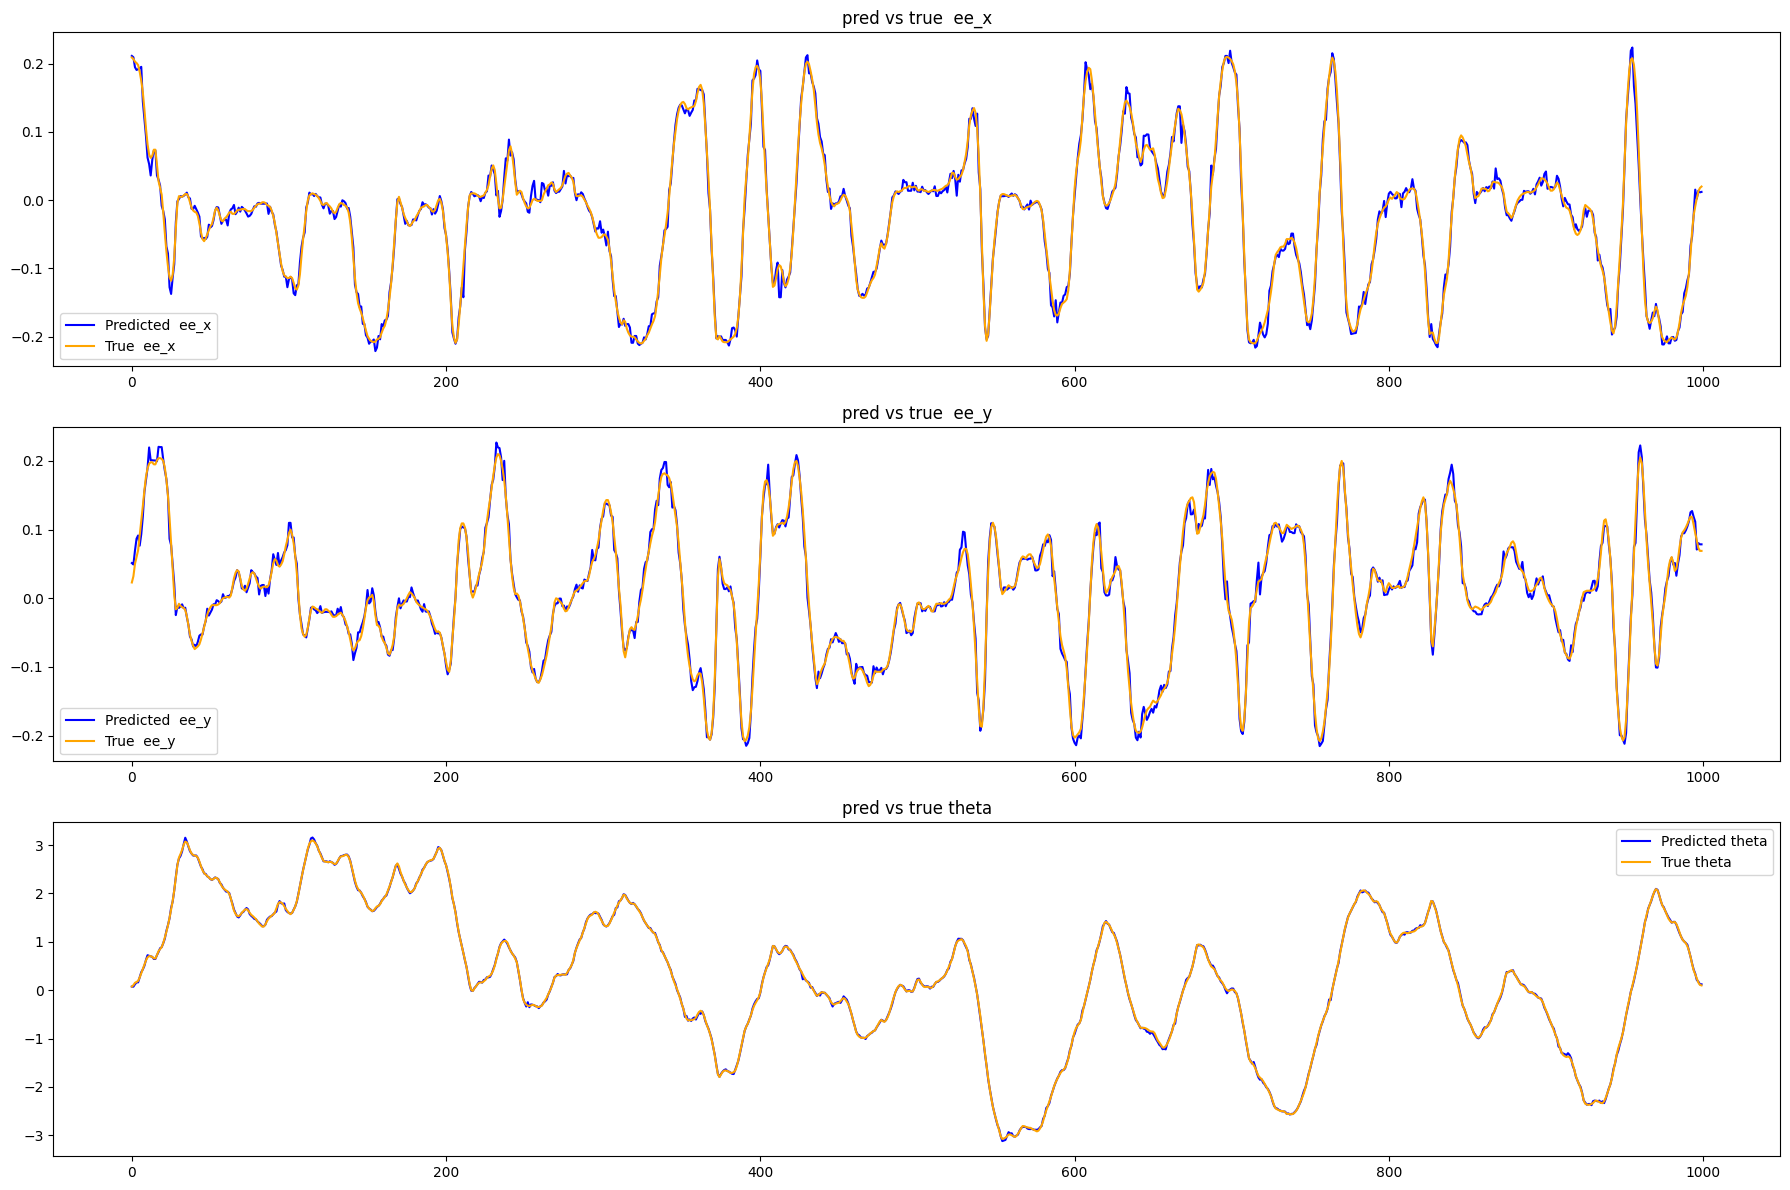

In [ ]:
plot_results(y_pred,y_test,target2,1000)

MODULO 3

In [ ]:
df=pd.read_csv("r5_20_100k.csv",sep=';',header=0)
df.describe()

j0             j1             j2             j3  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.025434       0.015859       0.007399       0.007597   
std         1.120495       1.111961       1.118099       1.121533   
min        -1.772000      -1.814000      -1.789000      -1.788000   
25%        -1.069000      -1.053000      -1.086000      -1.089000   
50%         0.047000       0.019000       0.019000       0.012000   
75%         1.122000       1.104000       1.097000       1.106000   
max         1.762000       1.782000       1.781000       1.792000   

                  j4        cos(j0)        cos(j1)        cos(j2)  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.013346       0.466104       0.474716       0.468671   
std         1.119534       0.369554       0.374505       0.370743   
min        -1.790000      -0.200000      -0.241000      -0.216000   
25%        -1.072250       0.097000       0.097000       0.100000   
50%         0.020000       0.458000       0.472000       0.461000   
75%         1.114000       0.832000       0.853000       0.839000   
max         1.779000       1.000000       1.000000       1.000000   

             cos(j3)        cos(j4)  ...        sin(j2)        sin(j3)  \
count  100000.000000  100000.000000  ...  100000.000000  100000.000000   
mean        0.465603       0.467289  ...       0.005392       0.005543   
std         0.370790       0.370414  ...       0.801809       0.803574   
min        -0.219000      -0.218000  ...      -1.000000      -1.000000   
25%         0.096000       0.100000  ...      -0.885000      -0.886000   
50%         0.456000       0.460000  ...       0.019000       0.012000   
75%         0.837000       0.838000  ...       0.890000       0.894000   
max         1.000000       1.000000  ...       1.000000       1.000000   

             sin(j4)           ee_x           ee_y           ee_z  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.008677       0.001730      -0.001777       0.228794   
std         0.802739       0.153567       0.188693       0.184390   
min        -1.000000      -0.448000      -0.452000      -0.215000   
25%        -0.878000      -0.113000      -0.145000       0.069000   
50%         0.020000       0.002000      -0.003000       0.265000   
75%         0.897000       0.115000       0.140000       0.383000   
max         1.000000       0.448000       0.453000       0.590000   

               ee_qw          ee_qx          ee_qy          ee_qz  
count  100000.000000  100000.000000  100000.000000  100000.000000  
mean        0.443297       0.010025       0.010099       0.004729  
std         0.359363       0.442641       0.531500       0.442390  
min        -0.767000      -0.762000      -0.999000      -0.761000  
25%         0.249000      -0.390000      -0.493250      -0.397000  
50%         0.565000       0.017000       0.020000       0.009000  
75%         0.701000       0.412000       0.513000       0.405000  
max         1.000000       0.772000       0.997000       0.762000  

[8 rows x 22 columns]

In [ ]:
df.columns

Index(['j0', ' j1', ' j2', ' j3', ' j4', ' cos(j0)', ' cos(j1)', ' cos(j2)',
       ' cos(j3)', ' cos(j4)', ' sin(j0)', ' sin(j1)', ' sin(j2)', ' sin(j3)',
       ' sin(j4)', ' ee_x', ' ee_y', ' ee_z', ' ee_qw', ' ee_qx', ' ee_qy',
       ' ee_qz'],
      dtype='object')

In [ ]:
feature5=['j0', ' j1', ' j2', ' j3', ' j4']
target5=[' ee_x',' ee_y',' ee_z',' ee_qw', ' ee_qx',' ee_qy',' ee_qz']
fea=df[feature5].values
tar=df[target5].values

x_train, x_test,y_train, y_test = train_test_split(fea,tar,test_size=0.2,random_state=1234,shuffle=True)

scaler = StandardScaler()

x_train= scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
model= KNeighborsRegressor(n_neighbors=5,weights='distance')
t0=time.time()
model.fit(x_train, y_train)
t1=time.time()
print(f'tempo di esecuzione:{t1-t0}')

tempo di esecuzione:0.10263562202453613


In [ ]:
y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.0007179417717683276
Mean Absolute Error: 0.018952662920218712


In [ ]:
df_test=pd.read_csv("r5_21_100k.csv",sep=';',header=0)
x_train=fea
y_train=tar
x_test=df_test[feature5].values
y_test=df_test[target5].values

scaler = StandardScaler()

x_train= scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
model= KNeighborsRegressor(n_neighbors=5,weights='distance')
t0=time.time()
model.fit(x_train, y_train)
t1=time.time()
print(f'tempo di esecuzione:{t1-t0}')

tempo di esecuzione:0.11601567268371582


In [ ]:
y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.0012092228225935807
Mean Absolute Error: 0.024863819388361453


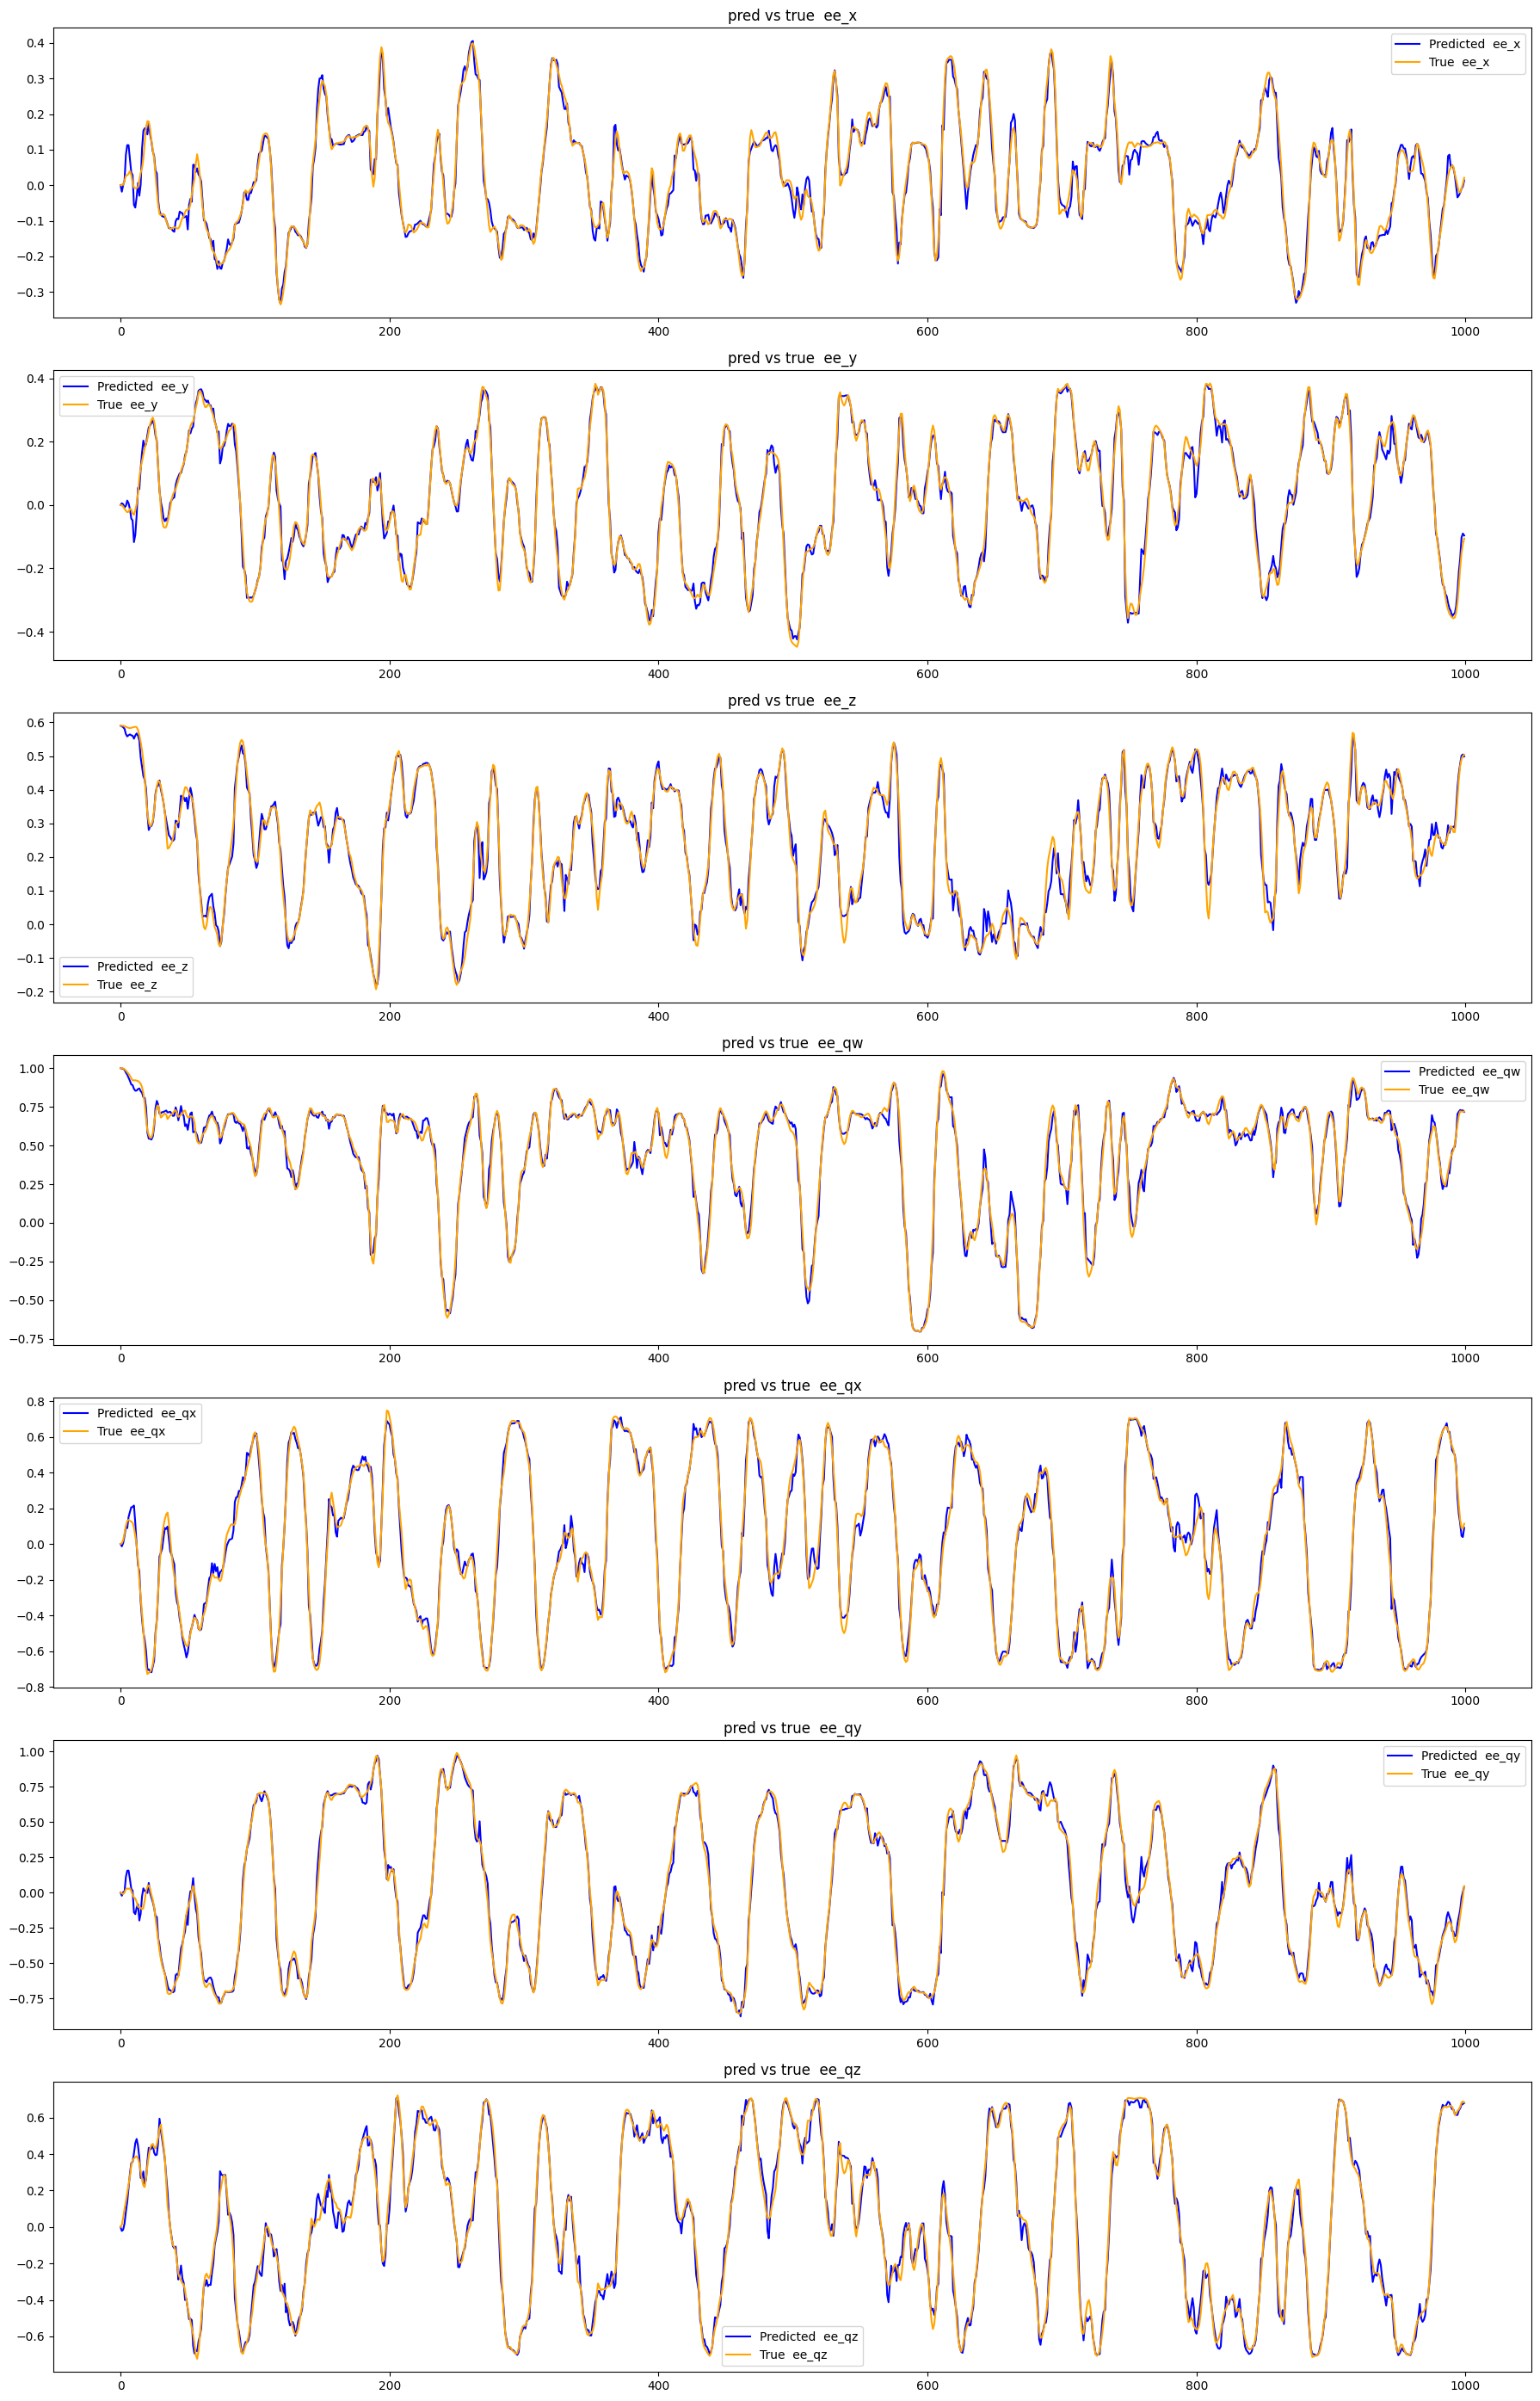

In [ ]:
plot_results(y_pred,y_test,target5,1000)

In [ ]:
df=pd.read_csv("r5_20-27.csv")
fea=df[feature5].values
tar=df[target5].values

In [ ]:
# @title CROSSVALIDATIONIPERKNNREGRESSORE(K,W)
kf=KFold(n_splits=4,shuffle=True,random_state=1234)

score_dictionary={}

for (train_index, vali_index) in kf.split(fea):
  x_train = fea[train_index]
  y_train = tar[train_index]
  x_vali = fea[vali_index]
  y_vali = tar[vali_index]

  scaler = StandardScaler()
  x_train= scaler.fit_transform(x_train)
  x_vali = scaler.transform(x_vali)

  for k in k_neighbors:
    for w in weights:
      knn_regressor = KNeighborsRegressor(n_neighbors=k, weights=w)
      knn_regressor.fit(x_train, y_train)
      y_pred = knn_regressor.predict(x_vali)

      #mse = mean_squared_error(y_vali, y_pred)
      mae = mean_absolute_error(y_vali, y_pred)

      # Verifica se la chiave esiste, altrimenti inizializzala come lista vuota
      if (k, w) not in score_dictionary:
        score_dictionary[(k, w)] = []
        print('pippo')
      score_dictionary[(k,w)].append(mae)
      print(f'Mean Absolute Error:{mae} k_nn:{k} ,weights:{w}')


pippo
Mean Absolute Error:0.015466958571430713 k_nn:3 ,weights:uniform
pippo
Mean Absolute Error:0.014927632789617023 k_nn:3 ,weights:distance
pippo
Mean Absolute Error:0.013929430857143496 k_nn:5 ,weights:uniform
pippo
Mean Absolute Error:0.013311765337213542 k_nn:5 ,weights:distance
pippo
Mean Absolute Error:0.013263033367344372 k_nn:7 ,weights:uniform
pippo
Mean Absolute Error:0.012611011624747407 k_nn:7 ,weights:distance
Mean Absolute Error:0.015478343809525905 k_nn:3 ,weights:uniform
Mean Absolute Error:0.014941947038801065 k_nn:3 ,weights:distance
Mean Absolute Error:0.013957391714286246 k_nn:5 ,weights:uniform
Mean Absolute Error:0.013337740161653526 k_nn:5 ,weights:distance
Mean Absolute Error:0.013281564897956791 k_nn:7 ,weights:uniform
Mean Absolute Error:0.012633391667111523 k_nn:7 ,weights:distance
Mean Absolute Error:0.015490275952383056 k_nn:3 ,weights:uniform
Mean Absolute Error:0.014946390300953849 k_nn:3 ,weights:distance
Mean Absolute Error:0.013973108000000614 k_nn:5

In [ ]:
# @title RISULTATO DELLA CROSS VALIDATION
for k in k_neighbors:
  for w in weights:
    mean=np.mean(score_dictionary[(k,w)])
    std=np.std(score_dictionary[(k,w)])
    print(f'score of--k:{k}--w:{w}:-->mean:{mean:.6}(+/-){(std*2):.6}')


score of--k:3--w:uniform:-->mean:0.0154758(+/-)1.90799e-05
score of--k:3--w:distance:-->mean:0.0149357(+/-)1.71424e-05
score of--k:5--w:uniform:-->mean:0.0139482(+/-)3.6031e-05
score of--k:5--w:distance:-->mean:0.0133286(+/-)2.95472e-05
score of--k:7--w:uniform:-->mean:0.0132878(+/-)4.07002e-05
score of--k:7--w:distance:-->mean:0.0126379(+/-)3.98493e-05


In [ ]:
df_test=pd.read_csv("r5_28_100k.csv",sep=';',header=0)
x_train=fea
y_train=tar
x_test=df_test[feature5].values
y_test=df_test[target5].values

In [ ]:
k = 7
knn_regressor = KNeighborsRegressor(n_neighbors=k, weights='distance')

In [ ]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [ ]:
t0=time.time()
knn_regressor.fit(x_train, tar)
t1=time.time()
print(f'tempo di esecuzione:{t1-t0}')

tempo di esecuzione:1.5267395973205566


In [ ]:
y_pred = knn_regressor.predict(x_test)

In [ ]:


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.0003309365545451642
Mean Absolute Error: 0.012994432535267704


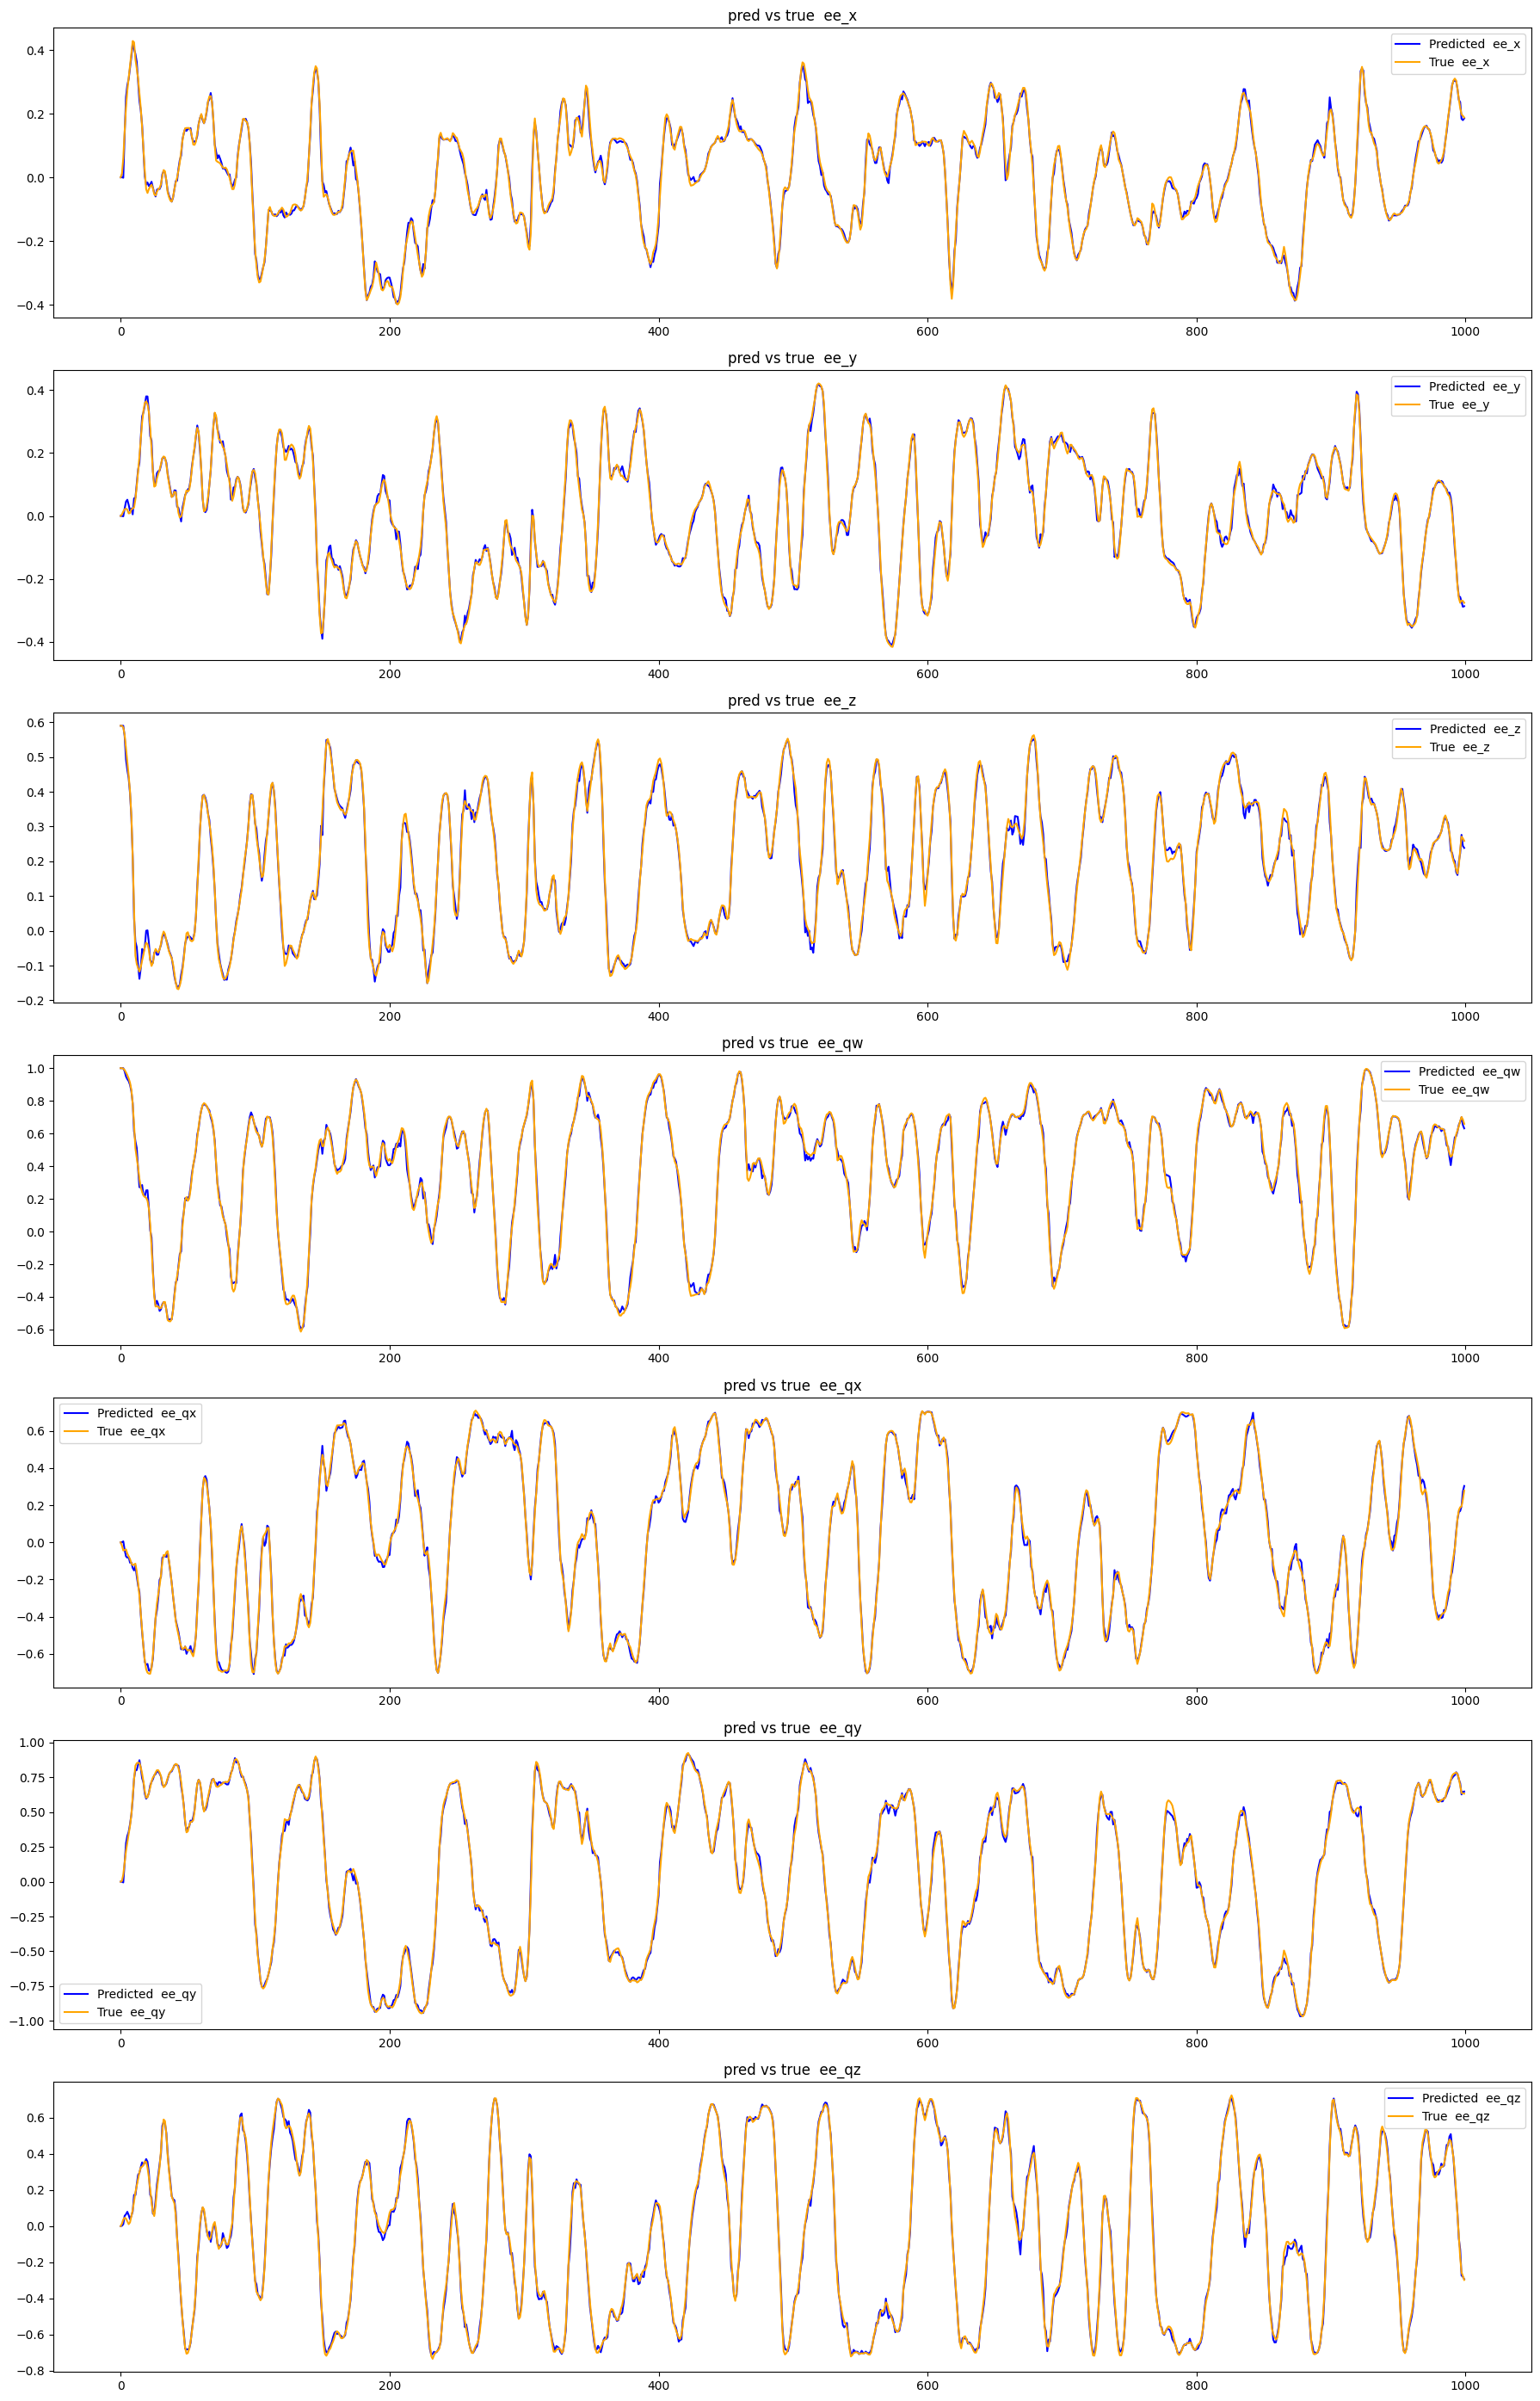

In [ ]:
plot_results(y_pred,y_test,target5,1000)

ANGULAR DISTANCE

In [ ]:
class AngularDistanceLoss(nn.Module):
    def __init__(self):
        super(AngularDistanceLoss, self).__init__()

    def forward(self, q_true, q_pred):
        dot_product = torch.sum(q_pred * q_true, dim=1)
        dot_product = torch.clamp(dot_product.abs(), max=1.0)
        angular_distance = 2 * torch.acos(dot_product)
        loss = angular_distance.mean()

        return loss

In [ ]:
class FFNN(nn.Module):
  def __init__(self, input_size, output_size, depth , num_layers, dropout):
    super(FFNN, self).__init__()
    layers = []
    layers.append(nn.Linear(input_size, depth).double())
    layers.append(nn.ReLU())
    for _ in range(num_layers - 1):
        layers.append(nn.Linear(depth, depth).double())
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
    layers.append(nn.Linear(depth, output_size).double())
    self.ffnn = nn.Sequential(*layers)

  def forward(self, x):
    out = self.ffnn(x)
    out = torch.cat([out[:, :3], out[:, 3:] / torch.norm(out[:, 3:], dim=1, keepdim=True)], dim=1)
    return out


In [ ]:
df=pd.read_csv("r5_20_100k.csv",sep=';',header=0)
df_test=pd.read_csv("r5_21_100k.csv",sep=';',header=0)
feature = ['j0', ' j1', ' j2', ' j3', ' j4']
target =[' ee_x', ' ee_y', ' ee_z', ' ee_qw', ' ee_qx', ' ee_qy', ' ee_qz']

In [ ]:
# @title funzione che implementa il training
def train_neural_network(model, train_loader, vali_loader, n_epochs, patience, verbose):
  train_loss_list=[]
  val_loss_list=[]
  mse=nn.MSELoss()
  early_stopping = EarlyStopping(patience=patience, verbose=verbose)
  for epoch in range(0, n_epochs):

    batch_train_loss=[]
    batch_val_loss=[]
    model.train()
    for xb,yb in train_loader:

      xb=xb.to(device)
      yb=yb.to(device)

      opt.zero_grad()
      pred=model(xb)
      loss=mse(yb[:,:3], pred[:,:3]) + loss_func(yb[:,3:],pred[:,3:])
      #loss=mse(yb, pred) + loss_func(yb[:,3:],pred[:,3:])
      loss.backward()
      opt.step()
      batch_train_loss.append(loss.item())
    train_loss_list.append(np.mean(batch_train_loss))
    model.eval()
    with torch.no_grad():
      for xb,yb in vali_loader:
        xb=xb.to(device)
        yb=yb.to(device)
        pred=model(xb)
        loss=loss_func(yb, pred)
        batch_val_loss.append(loss.item())
      val_loss_list.append(np.mean(batch_val_loss))
    early_stopping(val_loss_list[epoch], model)
    if early_stopping.early_stop:
      print(f"Early stopping at epoch:{epoch}")
      break
    print(f'Epoch{epoch}---train_loss={train_loss_list[epoch]:.4f}---val_loss={val_loss_list[epoch]:.4f}')
  return train_loss_list,val_loss_list

In [ ]:
x_train=df[feature].values
y_train=df[target].values
x_test=df_test[feature].values
y_test=df_test[target].values

scaler = StandardScaler()

x_train= scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = torch.tensor(x_train, dtype=torch.float64)
y_train = torch.tensor(y_train, dtype=torch.float64)

x_test = torch.tensor(x_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
vali_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

input_dim = len(feature)
output_size = len(target)
n_epochs=50

model= FFNN(input_dim, output_size, 128, 3, 0.1)

model.to(device)

loss_func =AngularDistanceLoss()
opt = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
t0=time.time()
train_loss_list,val_loss_list = train_neural_network(model, train_loader, vali_loader, n_epochs, patience= 10, verbose=True)
t1=time.time()
print(f'tempo di esecuzione:{t1-t0}')

Validation loss decreased (inf --> 0.004332).  Saving model ...
Epoch0---train_loss=0.2572---val_loss=0.0043
Validation loss decreased (0.004332 --> 0.002645).  Saving model ...
Epoch1---train_loss=0.1817---val_loss=0.0026
Validation loss decreased (0.002645 --> 0.001249).  Saving model ...
Epoch2---train_loss=0.1669---val_loss=0.0012
EarlyStopping counter: 1 out of 10
Epoch3---train_loss=0.1579---val_loss=0.0015
EarlyStopping counter: 2 out of 10
Epoch4---train_loss=0.1535---val_loss=0.0017
Validation loss decreased (0.001249 --> 0.000501).  Saving model ...
Epoch5---train_loss=0.1486---val_loss=0.0005
EarlyStopping counter: 1 out of 10
Epoch6---train_loss=0.1468---val_loss=0.0015
Validation loss decreased (0.000501 --> 0.000478).  Saving model ...
Epoch7---train_loss=0.1444---val_loss=0.0005
EarlyStopping counter: 1 out of 10
Epoch8---train_loss=0.1428---val_loss=0.0019
Validation loss decreased (0.000478 --> 0.000224).  Saving model ...
Epoch9---train_loss=0.1396---val_loss=0.0002
E

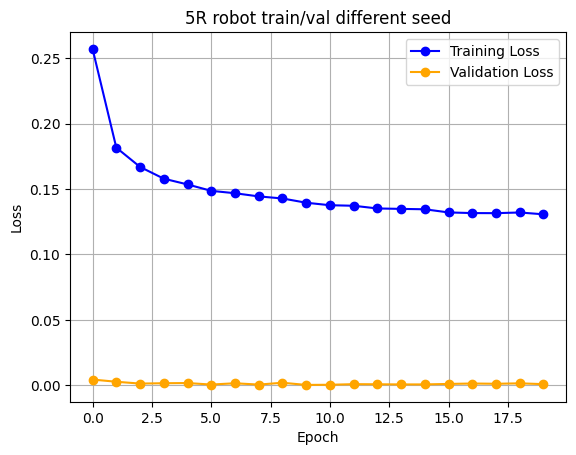

In [ ]:
plot_history(train_loss_list,val_loss_list,'5R robot train/val different seed')

In [ ]:
model.load_state_dict(torch.load('checkpoint.pt'))

<ipython-input-38-04102967a0dd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


<All keys matched successfully>

In [ ]:
model.to('cpu')
y_pred=model(x_test).detach()

angular =  loss_func(y_test[:,3:],y_pred[:,3:].detach())

In [ ]:
model.to('cpu')

y_pred=y_pred.numpy()
#angular =  loss_func(y_test[:,3:],y_pred[:,3:])
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Angular Distance: {angular}')

Mean Absolute Error: 0.0263392125315042
Mean Squared Error: 0.0016163496012227493
Angular Distance: 0.05479027792841622


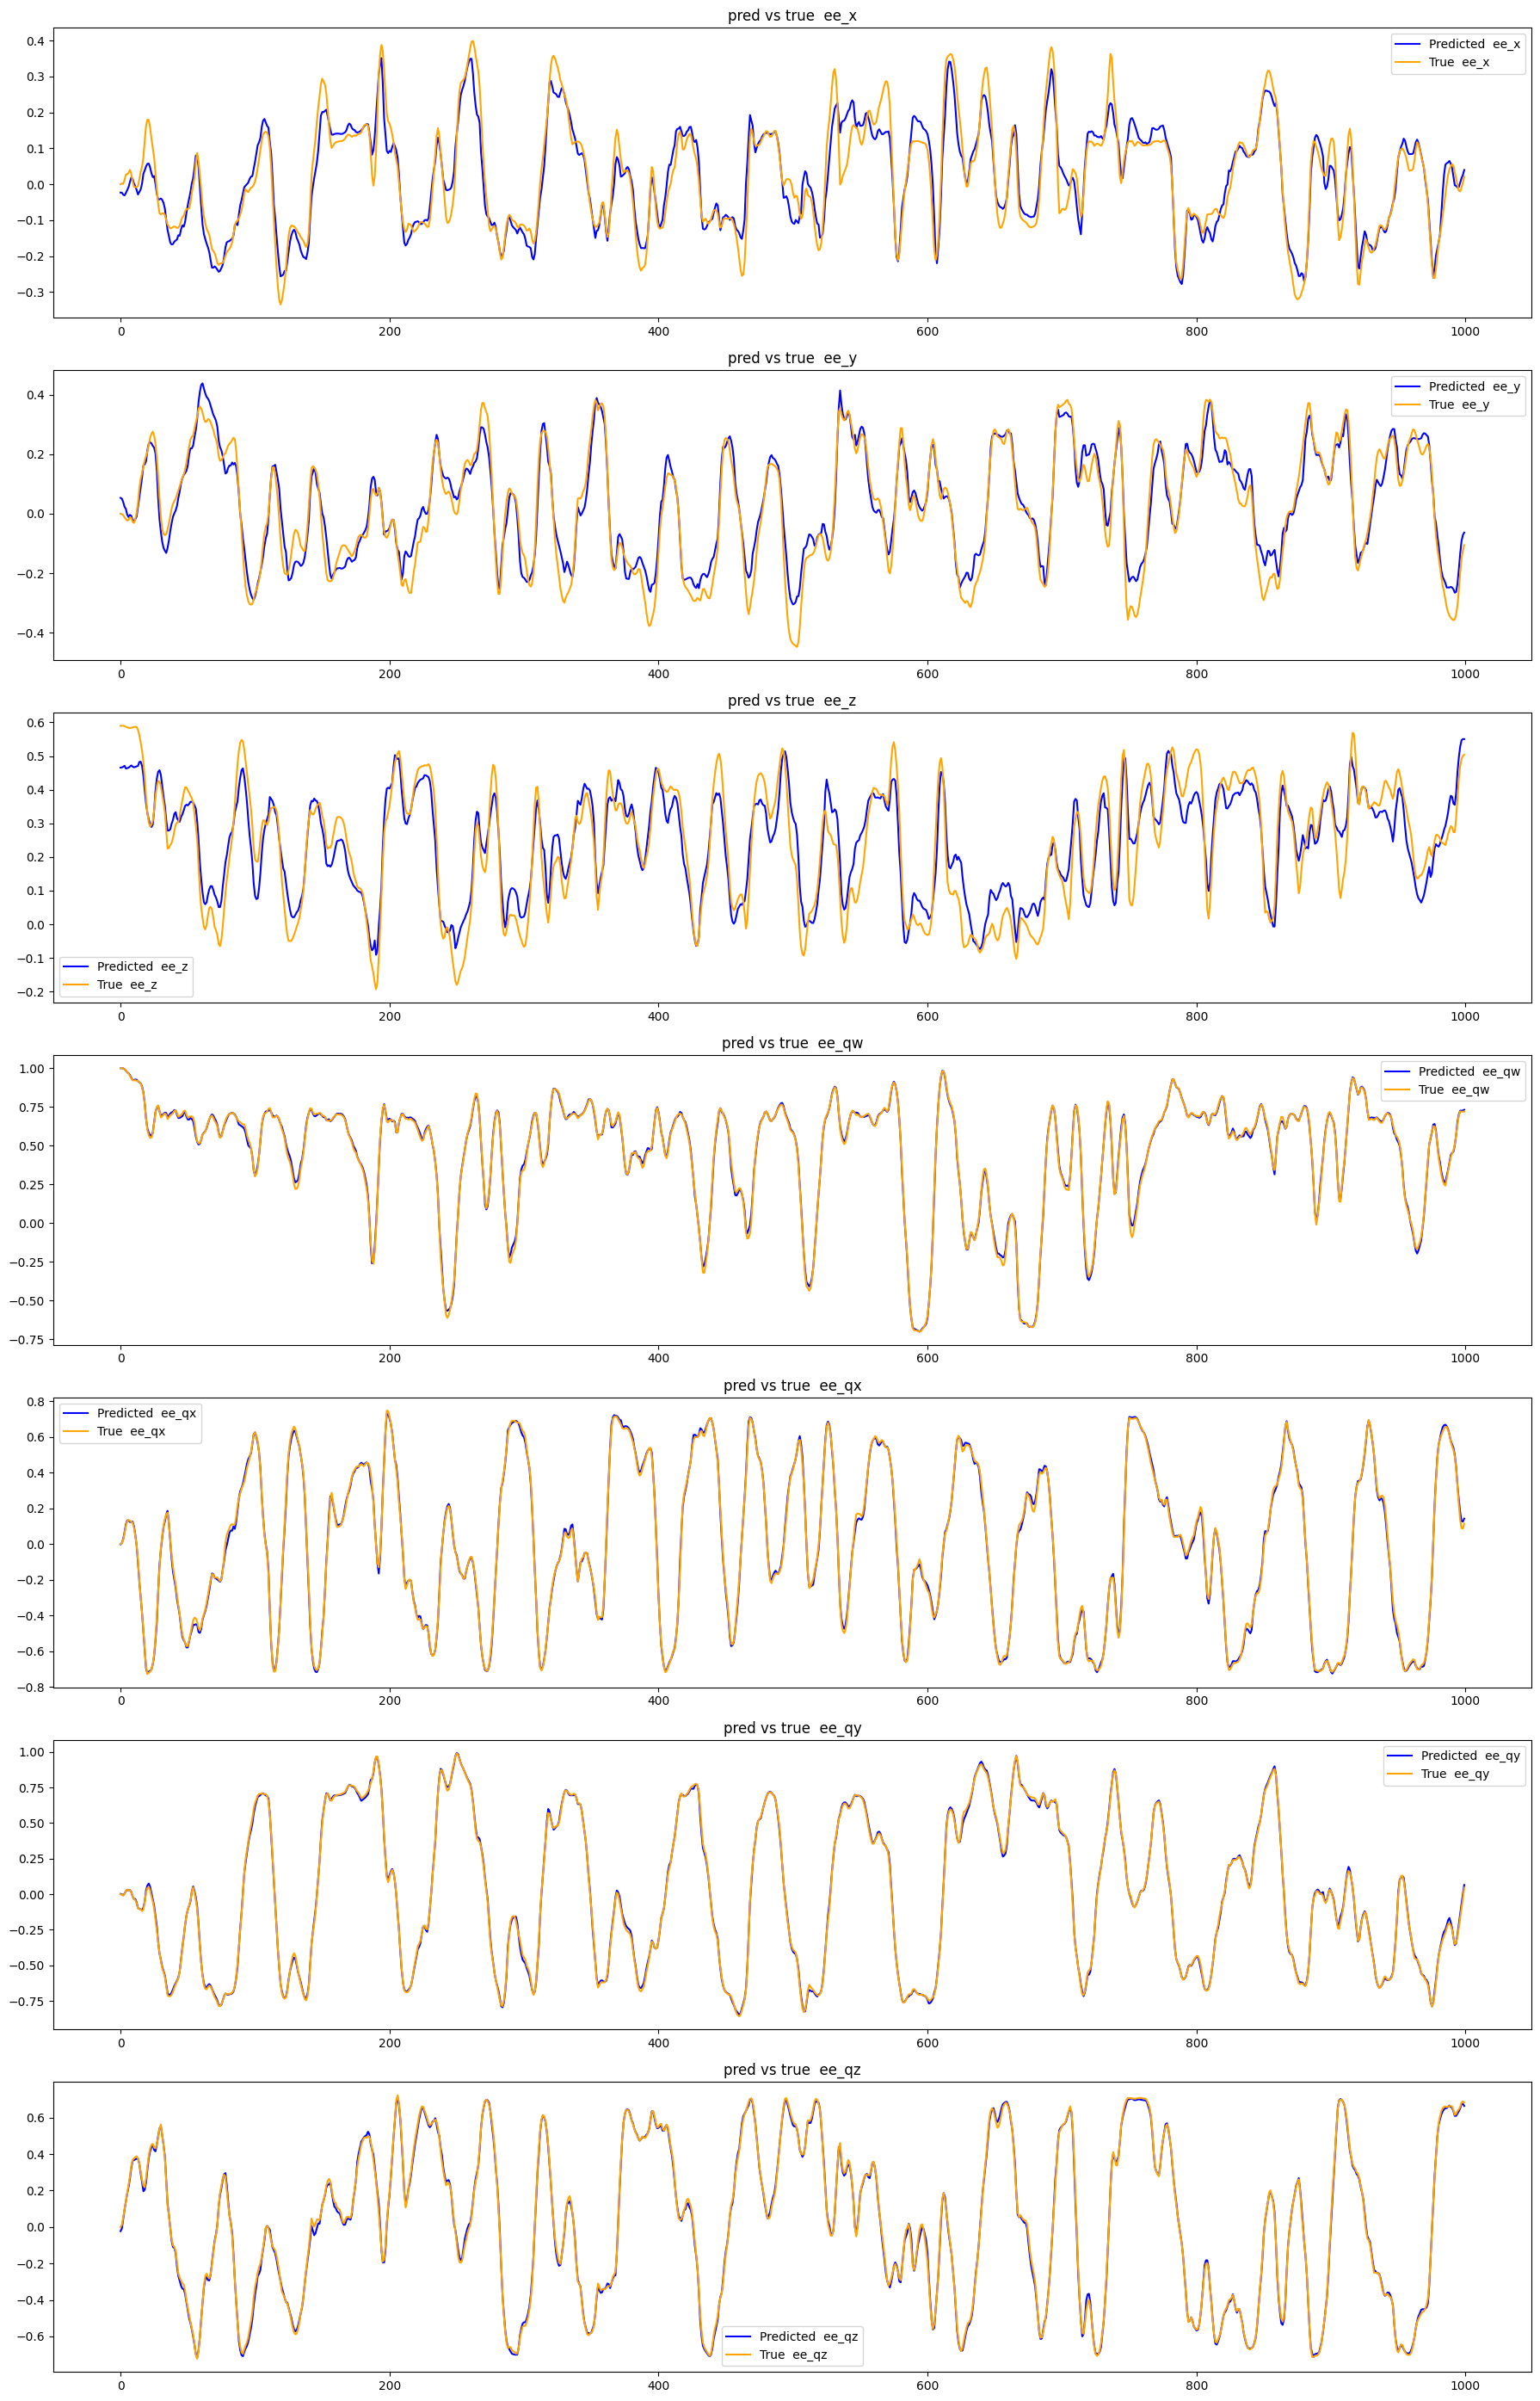

In [ ]:
plot_results(y_pred,y_test,target,1000)